In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# GARCH modeling
from arch.univariate import ConstantMean, GARCH, EGARCH, arch_model
from arch.univariate import Normal, StudentsT, SkewStudent

# Statistical tests
from scipy import stats
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Local imports
import sys
sys.path.append('src')
from models.garch import fit_garch, one_step_sigma
from eval.metrics import qlike
from eval.backtests import vol_target_weights, run_backtest
from data.features import garman_klass, realized_vol_from_daily

# Plotting configuration
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

print("Environment loaded successfully")

Environment loaded successfully


## 1. Data Loading and Preprocessing
We'll use SPY (S&P 500 ETF) daily data from 2015-2024 as our primary research dataset.

In [5]:
df = pd.read_parquet('data/processed/AAPL_features.parquet')

print(f"Data shape: {df.shape}")
print(f"Date range: {df.index[0]} to {df.index[-1]}")
print(f"\nSample data:")
df.head()

Data shape: (2695, 18)
Date range: 2015-02-06 00:00:00 to 2025-10-23 00:00:00

Sample data:


,open,high,low,close,volume,ret,logret,rv_target,rv_lag1,rv_lag5,rv_lag22,ret_1d,ret_5d,ret_22d,vol_22d,weekday,month,ticker
date,,,,,,,,,,,,,,,,,,
2015-02-06,26.738340,26.789581,26.388572,26.495508,174826400,-0.008421,-0.008457,0.410099,0.475384,0.520643,0.544024,0.007138,0.002578,0.005923,0.341151,4,2,AAPL
2015-02-09,26.410848,26.698236,26.384114,26.671503,155559200,0.006642,0.006620,0.303013,0.410099,0.503857,0.537368,-0.008421,0.003820,0.005536,0.344102,0,2,AAPL
2015-02-10,26.771752,27.212862,26.769525,27.183899,248034000,0.019211,0.019029,0.289036,0.303013,0.453461,0.524961,0.006642,0.002639,0.005200,0.342822,1,2,AAPL
2015-02-11,27.350982,27.829964,27.290831,27.821053,294247200,0.023439,0.023168,0.261613,0.289036,0.403446,0.509409,0.019211,0.006448,0.004327,0.326246,2,2,AAPL
2015-02-12,28.083948,28.400300,27.974785,28.173061,297898000,0.012653,0.012573,0.296280,0.261613,0.347829,0.494561,0.023439,0.009602,0.005344,0.332295,3,2,AAPL


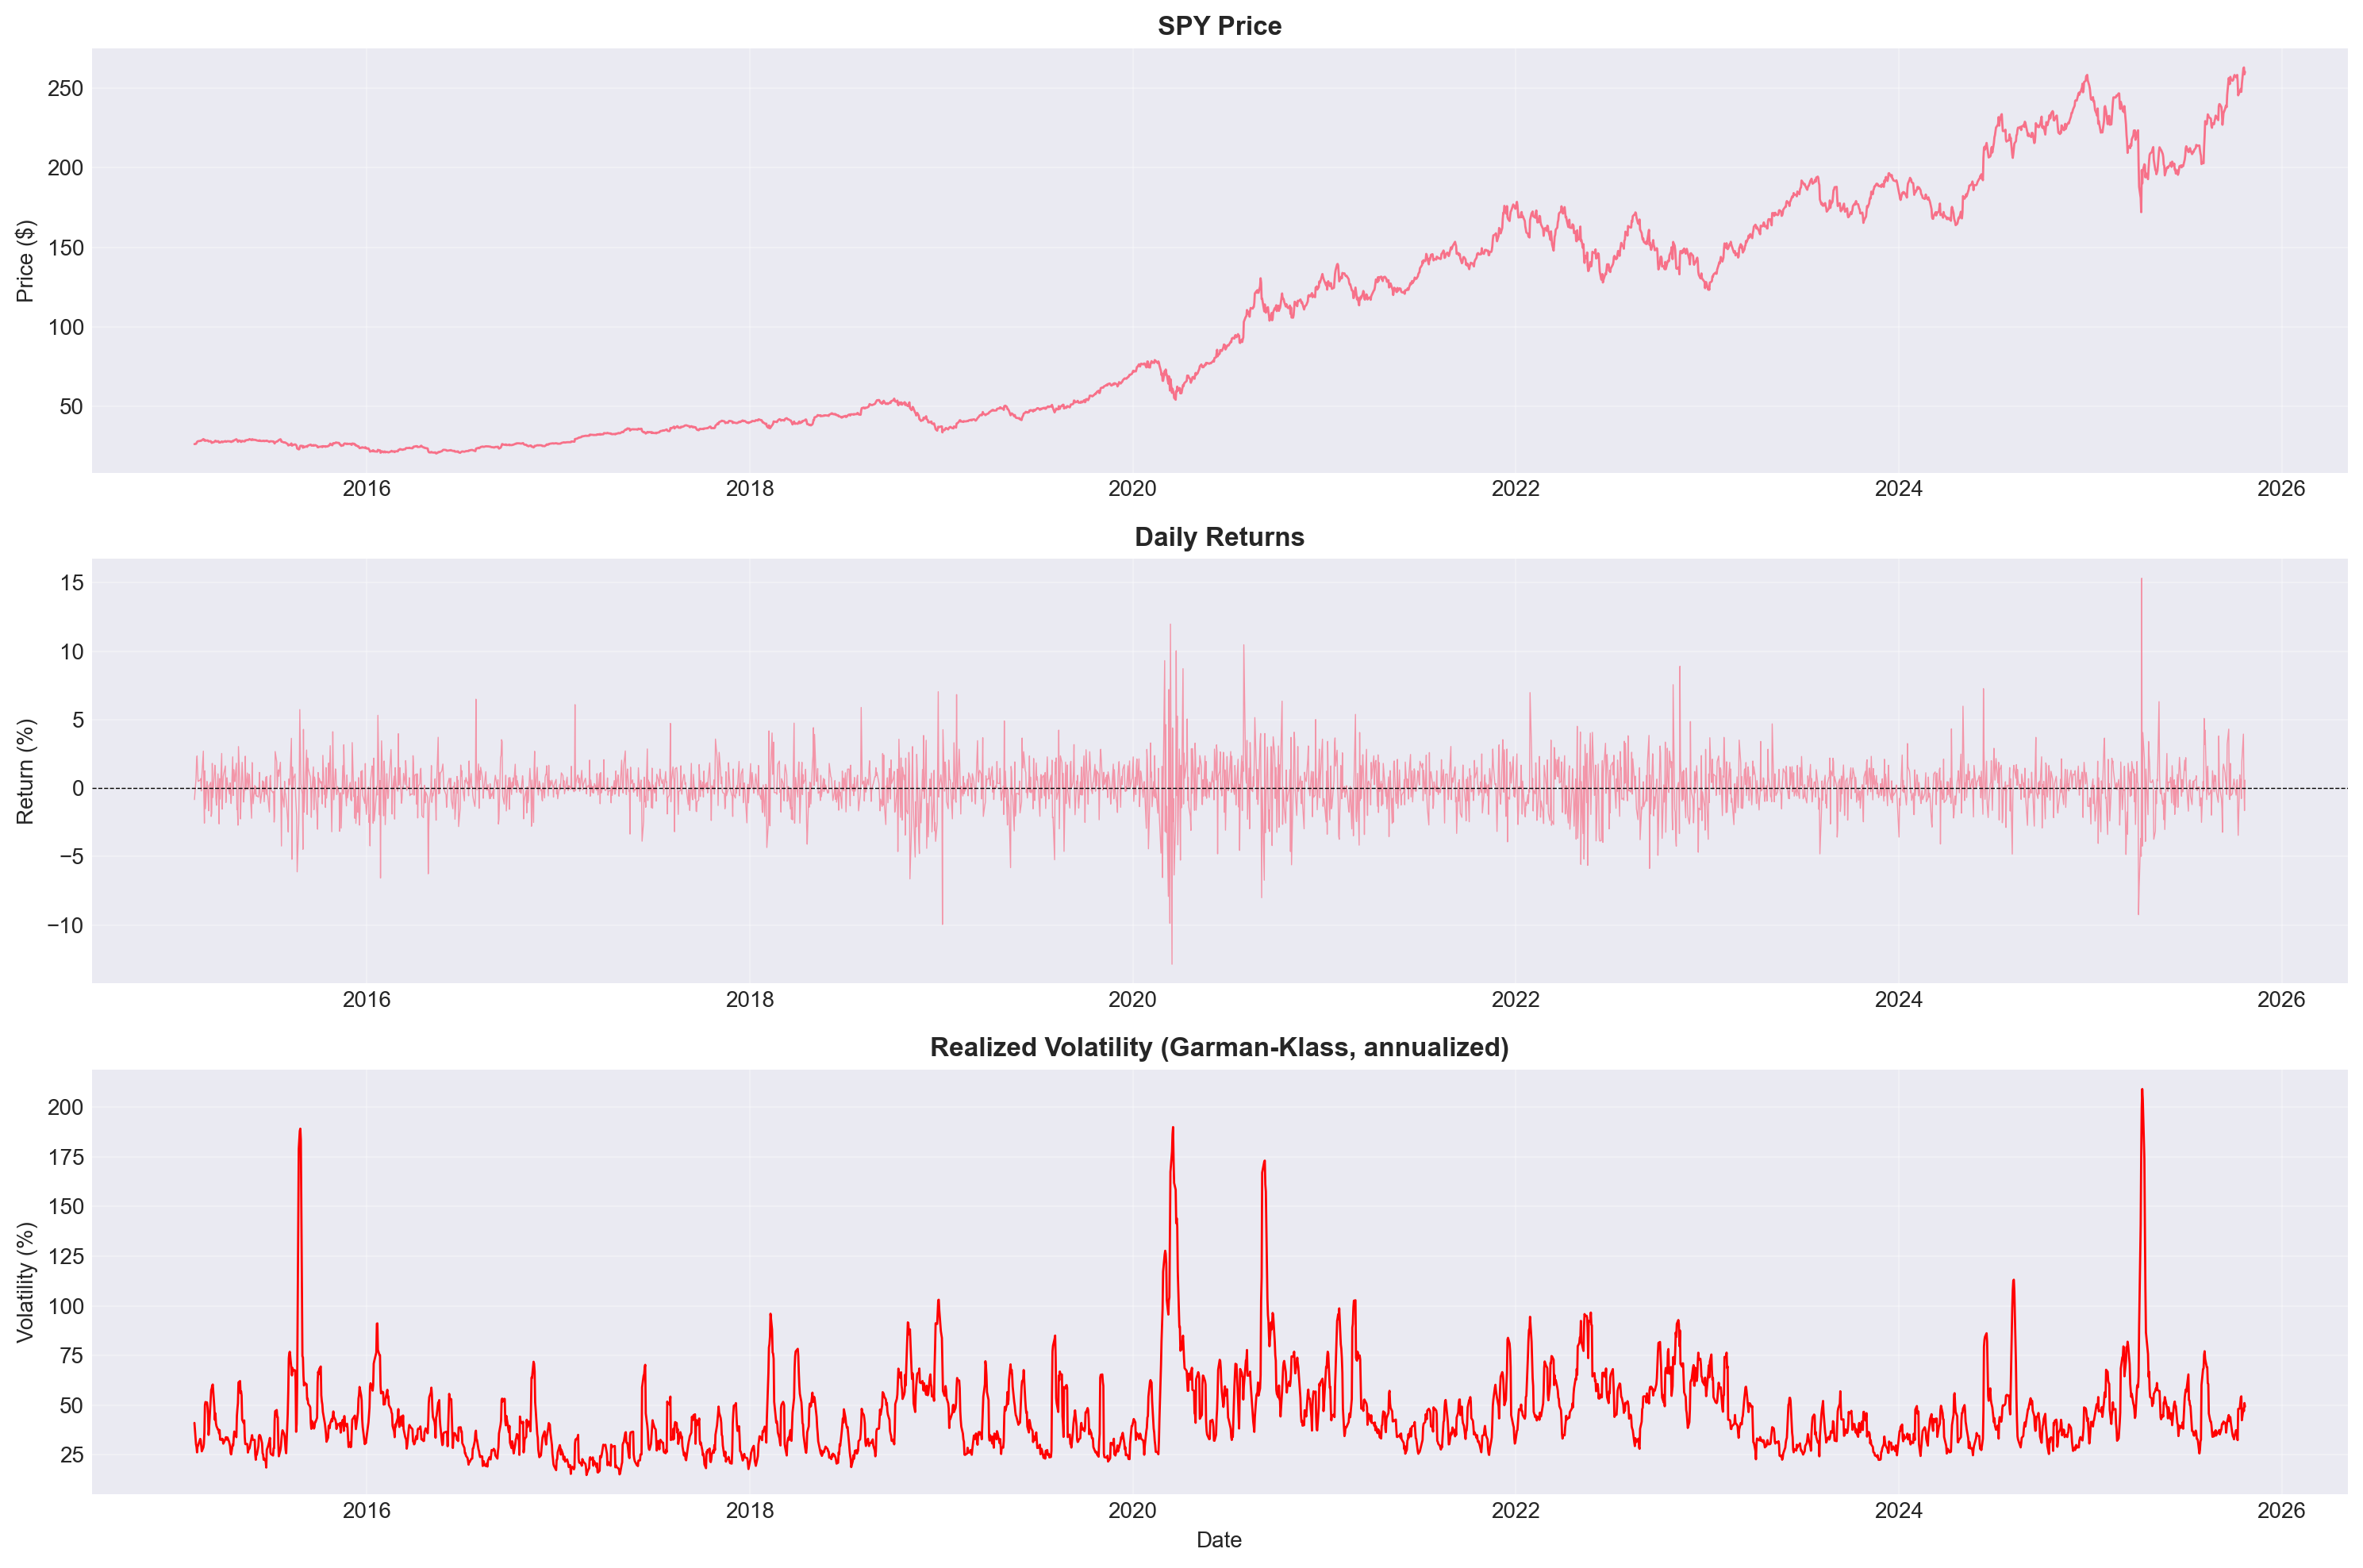


=== RETURN STATISTICS ===
Mean return: 25.48% annualized
Volatility: 28.98% annualized
Skewness: 0.135
Kurtosis: 6.578
Min return: -12.86%
Max return: 15.33%


In [7]:
# Visualize returns and volatility
fig, axes = plt.subplots(3, 1, figsize=(15, 10))

# Price
axes[0].plot(df.index, df['close'], linewidth=1)
axes[0].set_title('SPY Price', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Price ($)')
axes[0].grid(True, alpha=0.3)

# Returns
axes[1].plot(df.index, df['ret'] * 100, linewidth=0.5, alpha=0.7)
axes[1].set_title('Daily Returns', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Return (%)')
axes[1].axhline(y=0, color='black', linestyle='--', linewidth=0.5)
axes[1].grid(True, alpha=0.3)

# Realized Volatility
axes[2].plot(df.index, df['rv_target'] * 100, linewidth=1, color='red')
axes[2].set_title('Realized Volatility (Garman-Klass, annualized)', fontsize=12, fontweight='bold')
axes[2].set_ylabel('Volatility (%)')
axes[2].set_xlabel('Date')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary statistics
print("\n=== RETURN STATISTICS ===")
print(f"Mean return: {df['ret'].mean()*252*100:.2f}% annualized")
print(f"Volatility: {df['ret'].std()*np.sqrt(252)*100:.2f}% annualized")
print(f"Skewness: {stats.skew(df['ret'].dropna()):.3f}")
print(f"Kurtosis: {stats.kurtosis(df['ret'].dropna()):.3f}")
print(f"Min return: {df['ret'].min()*100:.2f}%")
print(f"Max return: {df['ret'].max()*100:.2f}%")

In [8]:

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

Possible peaks:
Lag 98: ACF = 0.1526
Lag 119: ACF = 0.1534
Lag 125: ACF = 0.1609
Lag 153: ACF = 0.1168


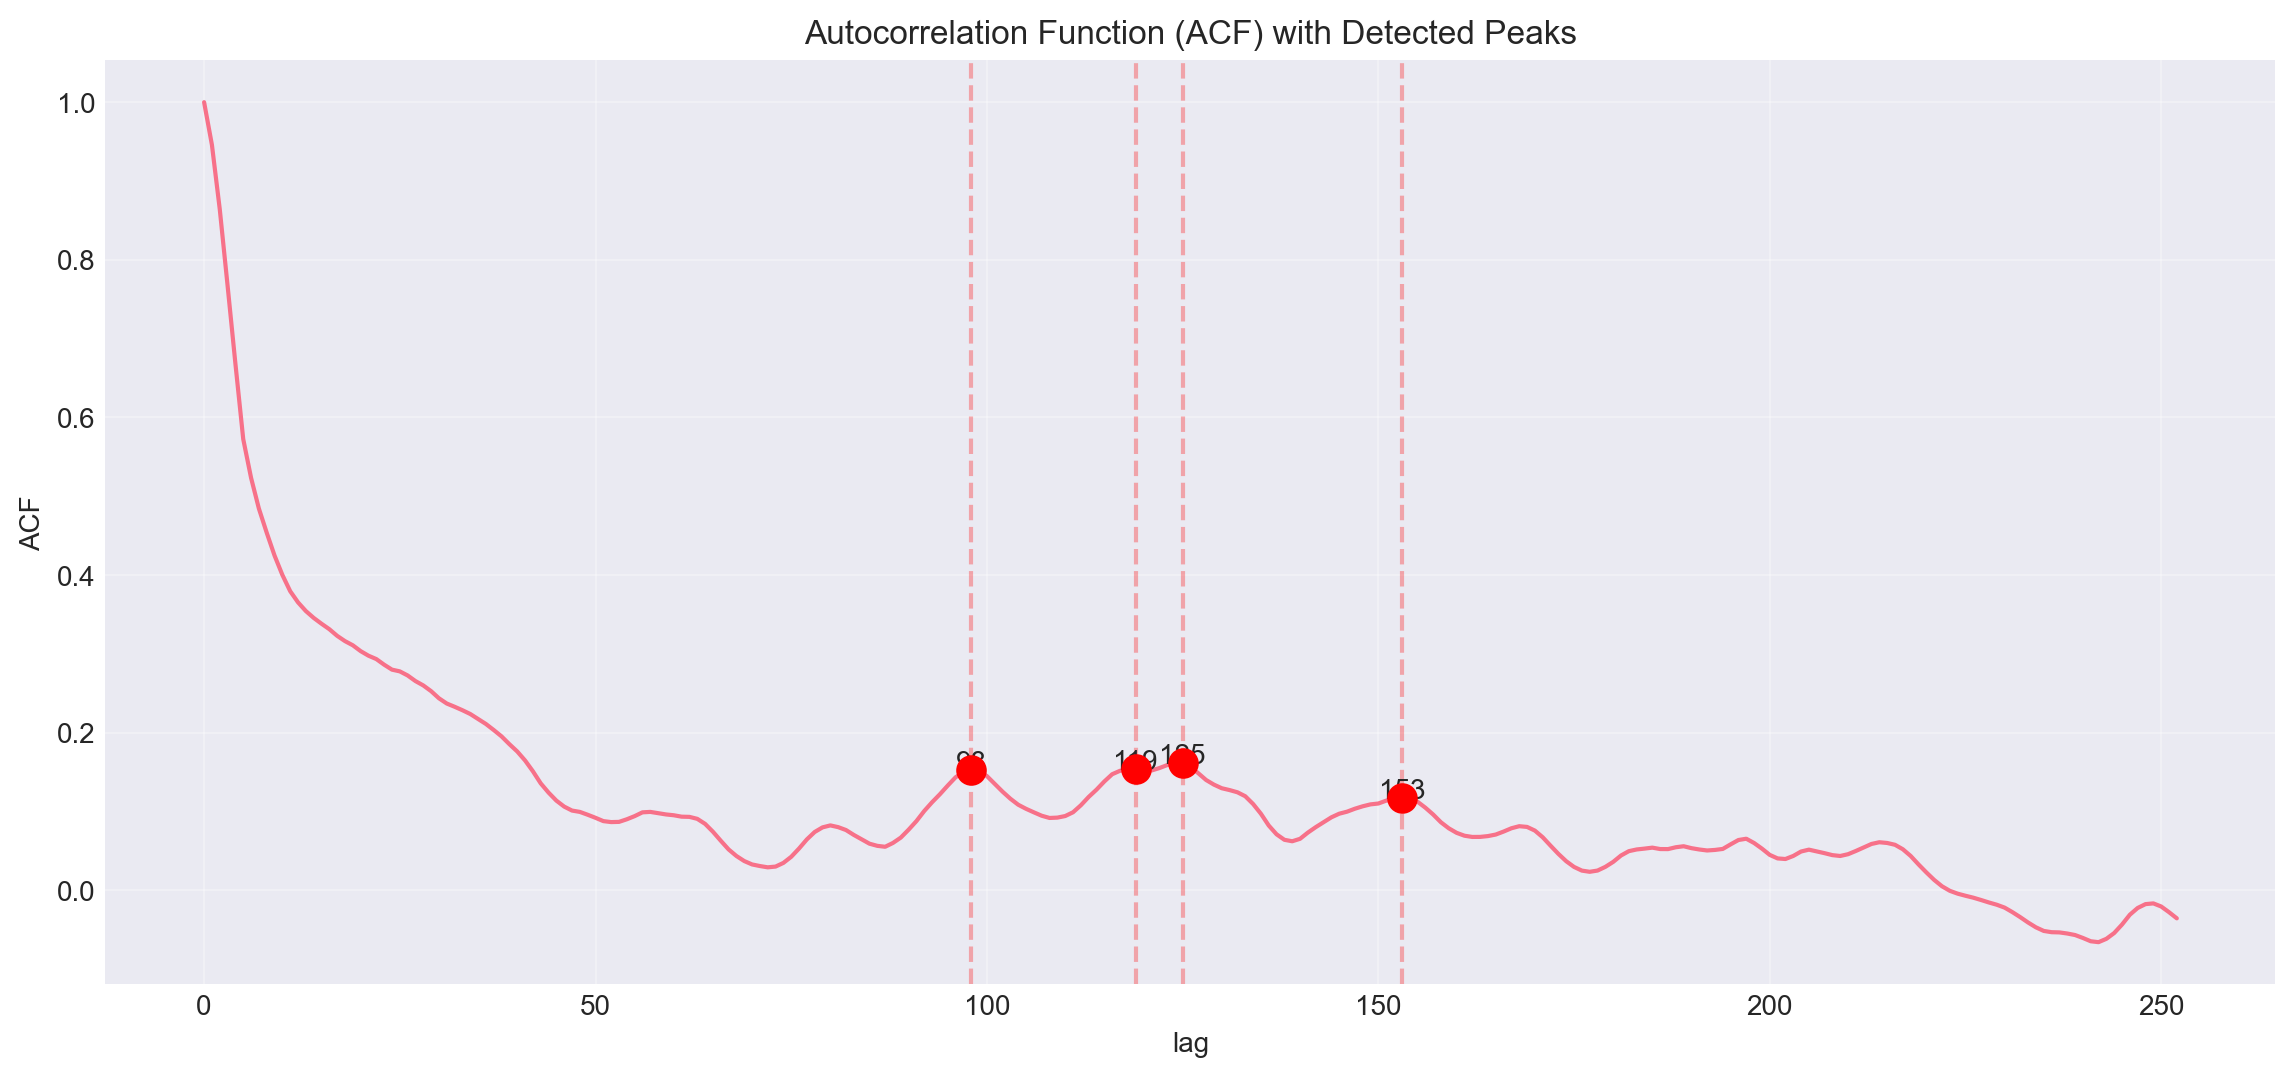

In [9]:
from statsmodels.tsa.stattools import acf, pacf


acf_vals = acf(df['rv_target'].dropna(), nlags=252, fft=True)


from scipy.signal import find_peaks

peaks, properties = find_peaks(acf_vals[1:], height=0.1, distance=5)
peaks = peaks + 1  # bc removed first lag

print("Possible peaks:")
for peak in peaks[:10]:  # top 10 peaks
    print(f"Lag {peak}: ACF = {acf_vals[peak]:.4f}")

# Визуализация
plt.figure(figsize=(14, 6))
plt.plot(acf_vals)
plt.scatter(peaks, acf_vals[peaks], color='red', s=100, zorder=5)
for peak in peaks[:5]:
    plt.axvline(x=peak, color='red', linestyle='--', alpha=0.3)
    plt.text(peak, acf_vals[peak], f'{peak}', ha='center')
plt.xlabel('lag')
plt.ylabel('ACF')
plt.title('Autocorrelation Function (ACF) with Detected Peaks')
plt.grid(alpha=0.3)
plt.show()


Top 5 strongest lags:
 lag      pacf  abs_pacf
   1  0.945796  0.945796
   6  0.408985  0.408985
   2 -0.286808  0.286808
  11  0.264202  0.264202
  16  0.175217  0.175217


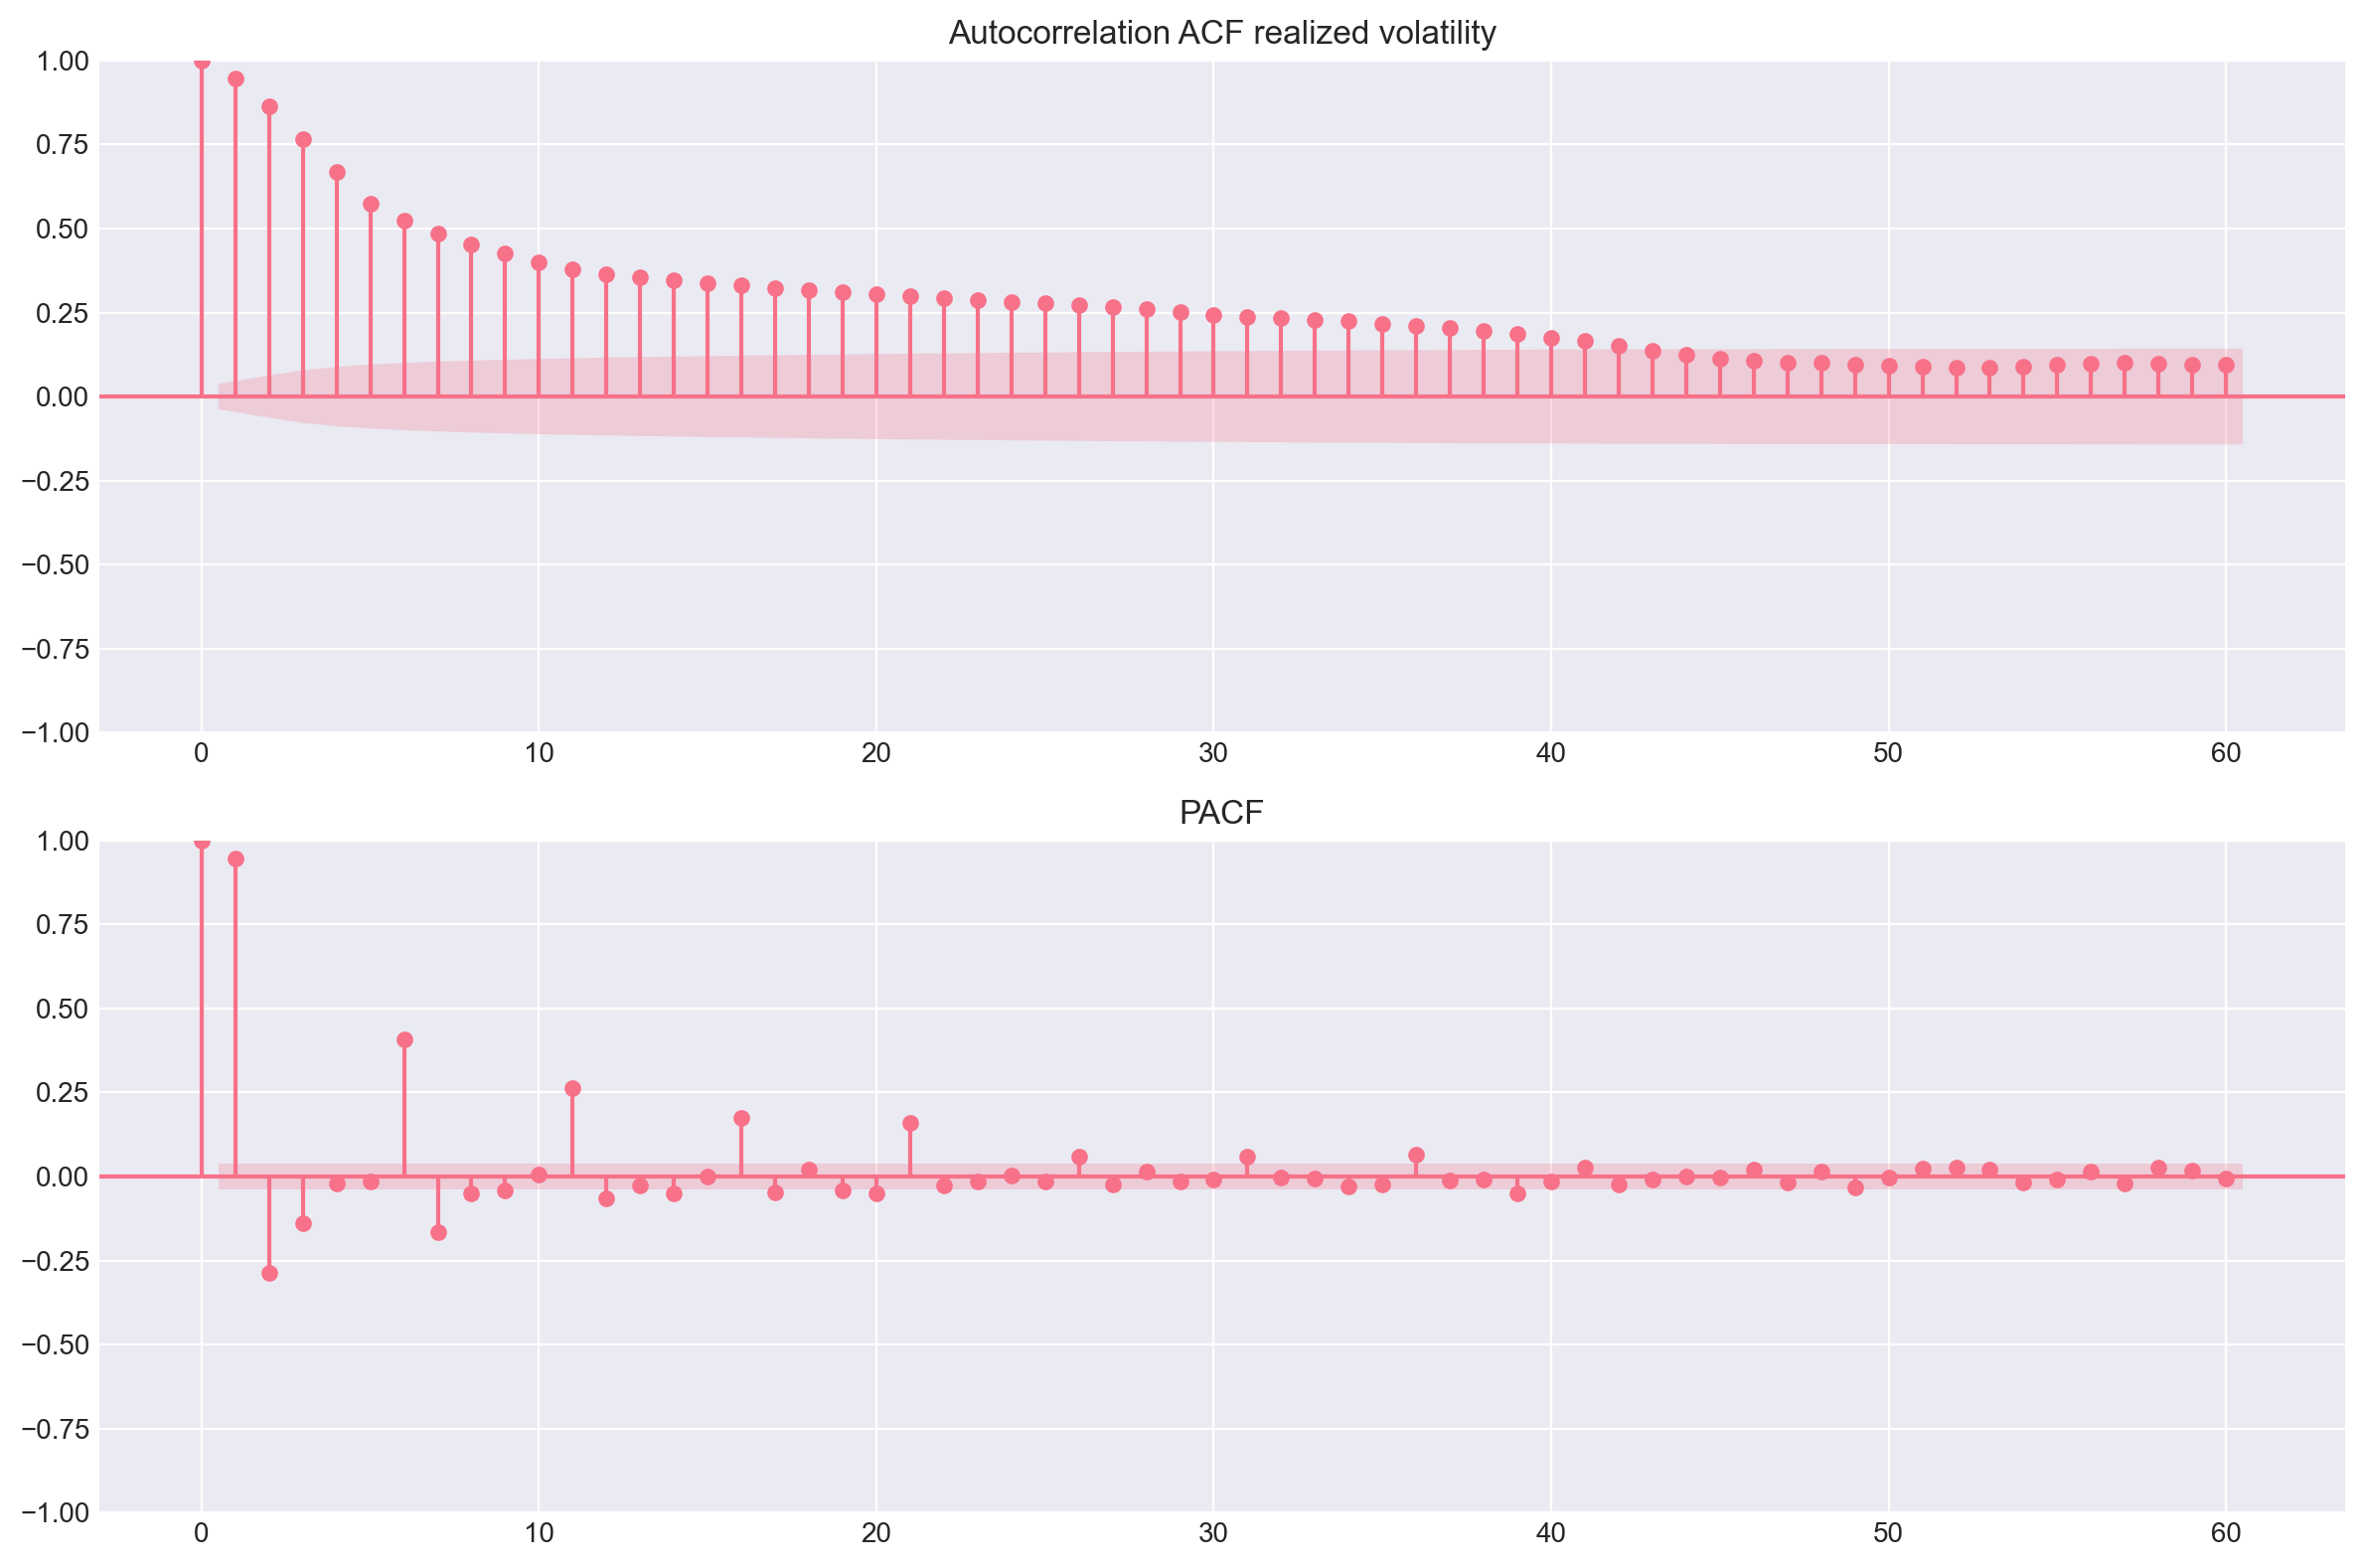

In [10]:
# we are interested in the 'rv_target' column (realized volatility) because it represents the target variable for volatility forecasting.

pacf_values = pacf(df['rv_target'].dropna(), nlags=60, method='ywm')

pacf_df = pd.DataFrame({
    'lag': range(len(pacf_values)),
    'pacf': pacf_values,
    'abs_pacf': np.abs(pacf_values)
})

# confidence interval
n = len(df['rv_target'].dropna())
confidence_bound = 1.96 / np.sqrt(n)

pacf_df['significant'] = pacf_df['abs_pacf'] > confidence_bound

# top 5 strongest lags (by absolute value)
print("\nTop 5 strongest lags:")
top_lags = pacf_df[pacf_df['lag'] > 0].nlargest(5, 'abs_pacf')
print(top_lags[['lag', 'pacf', 'abs_pacf']].to_string(index=False))

fig, axes = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(df['rv_target'].dropna(), lags=60, ax=axes[0])
axes[0].set_title('Autocorrelation ACF realized volatility')
plot_pacf(df['rv_target'].dropna(), lags=60, ax=axes[1])
axes[1].set_title('PACF')
plt.tight_layout()
plt.show()

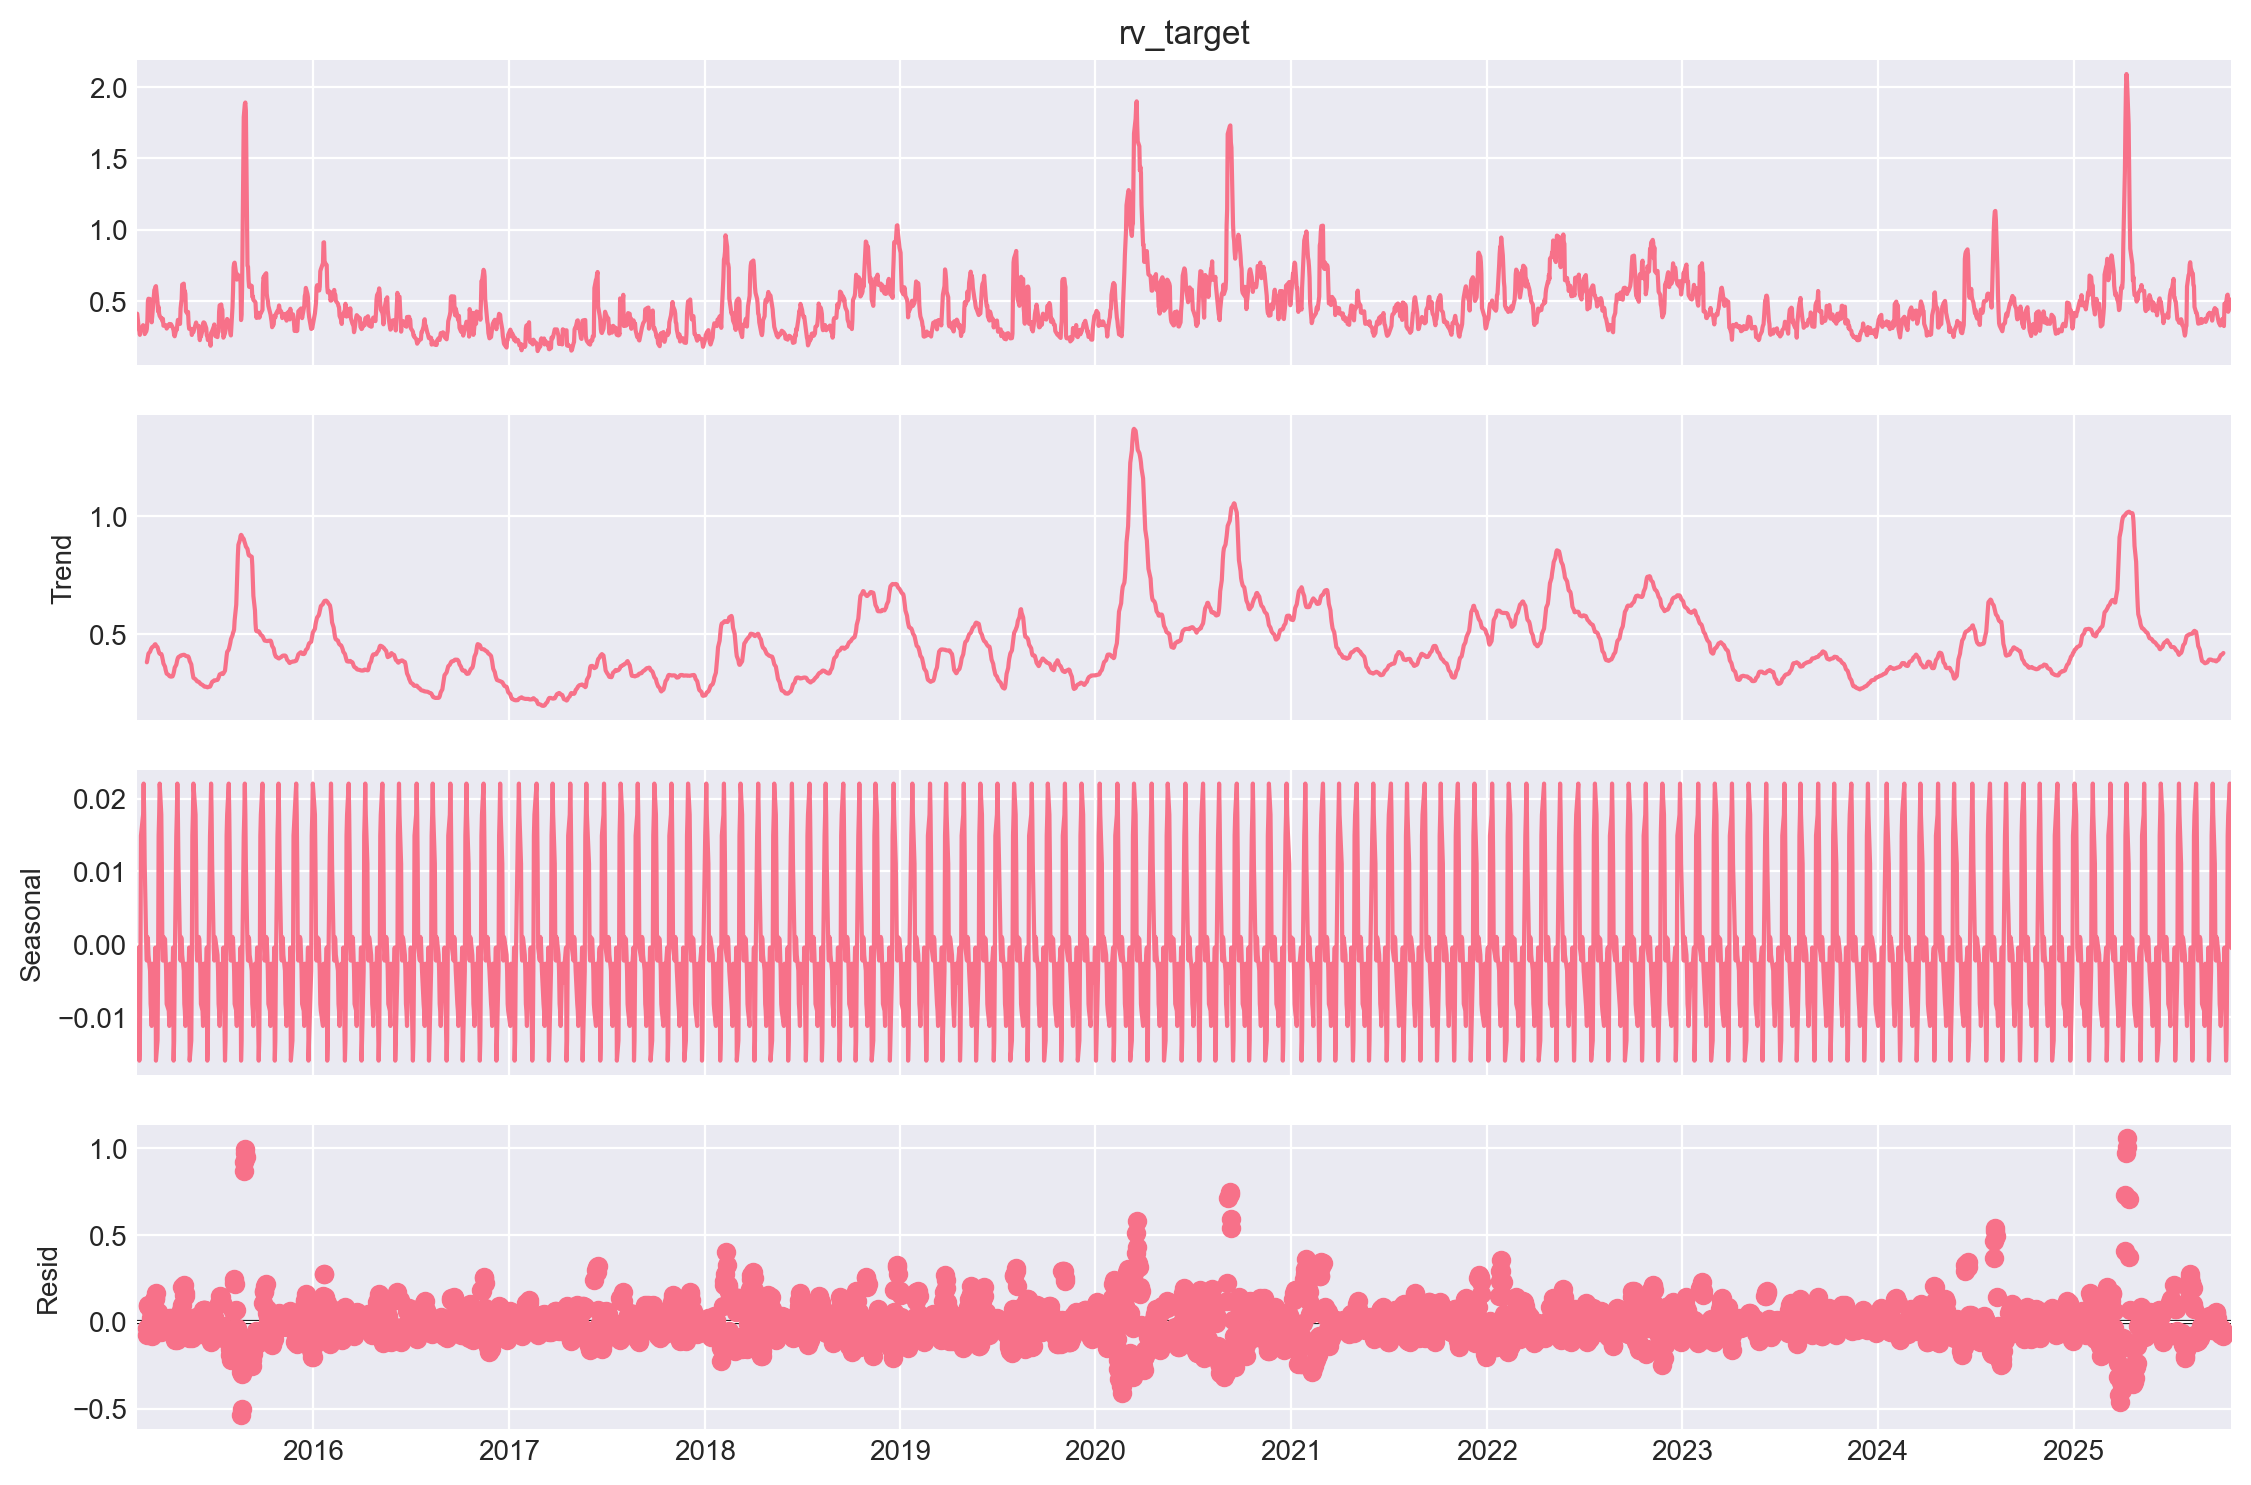

In [11]:
decomposition = seasonal_decompose(df['rv_target'].dropna(), 
                                   model='additive', 
                                   period=22)  
fig = decomposition.plot()
fig.set_size_inches(12, 8)
plt.show()

## 2. Stylized Facts of Financial Returns
Before modeling, we examine key stylized facts:

- Volatility clustering - large changes tend to follow large changes
- Heavy tails - extreme events more common than normal distribution suggests
- Leverage effect - negative returns increase volatility more than positive returns
- Long memory - volatility exhibits autocorrelation

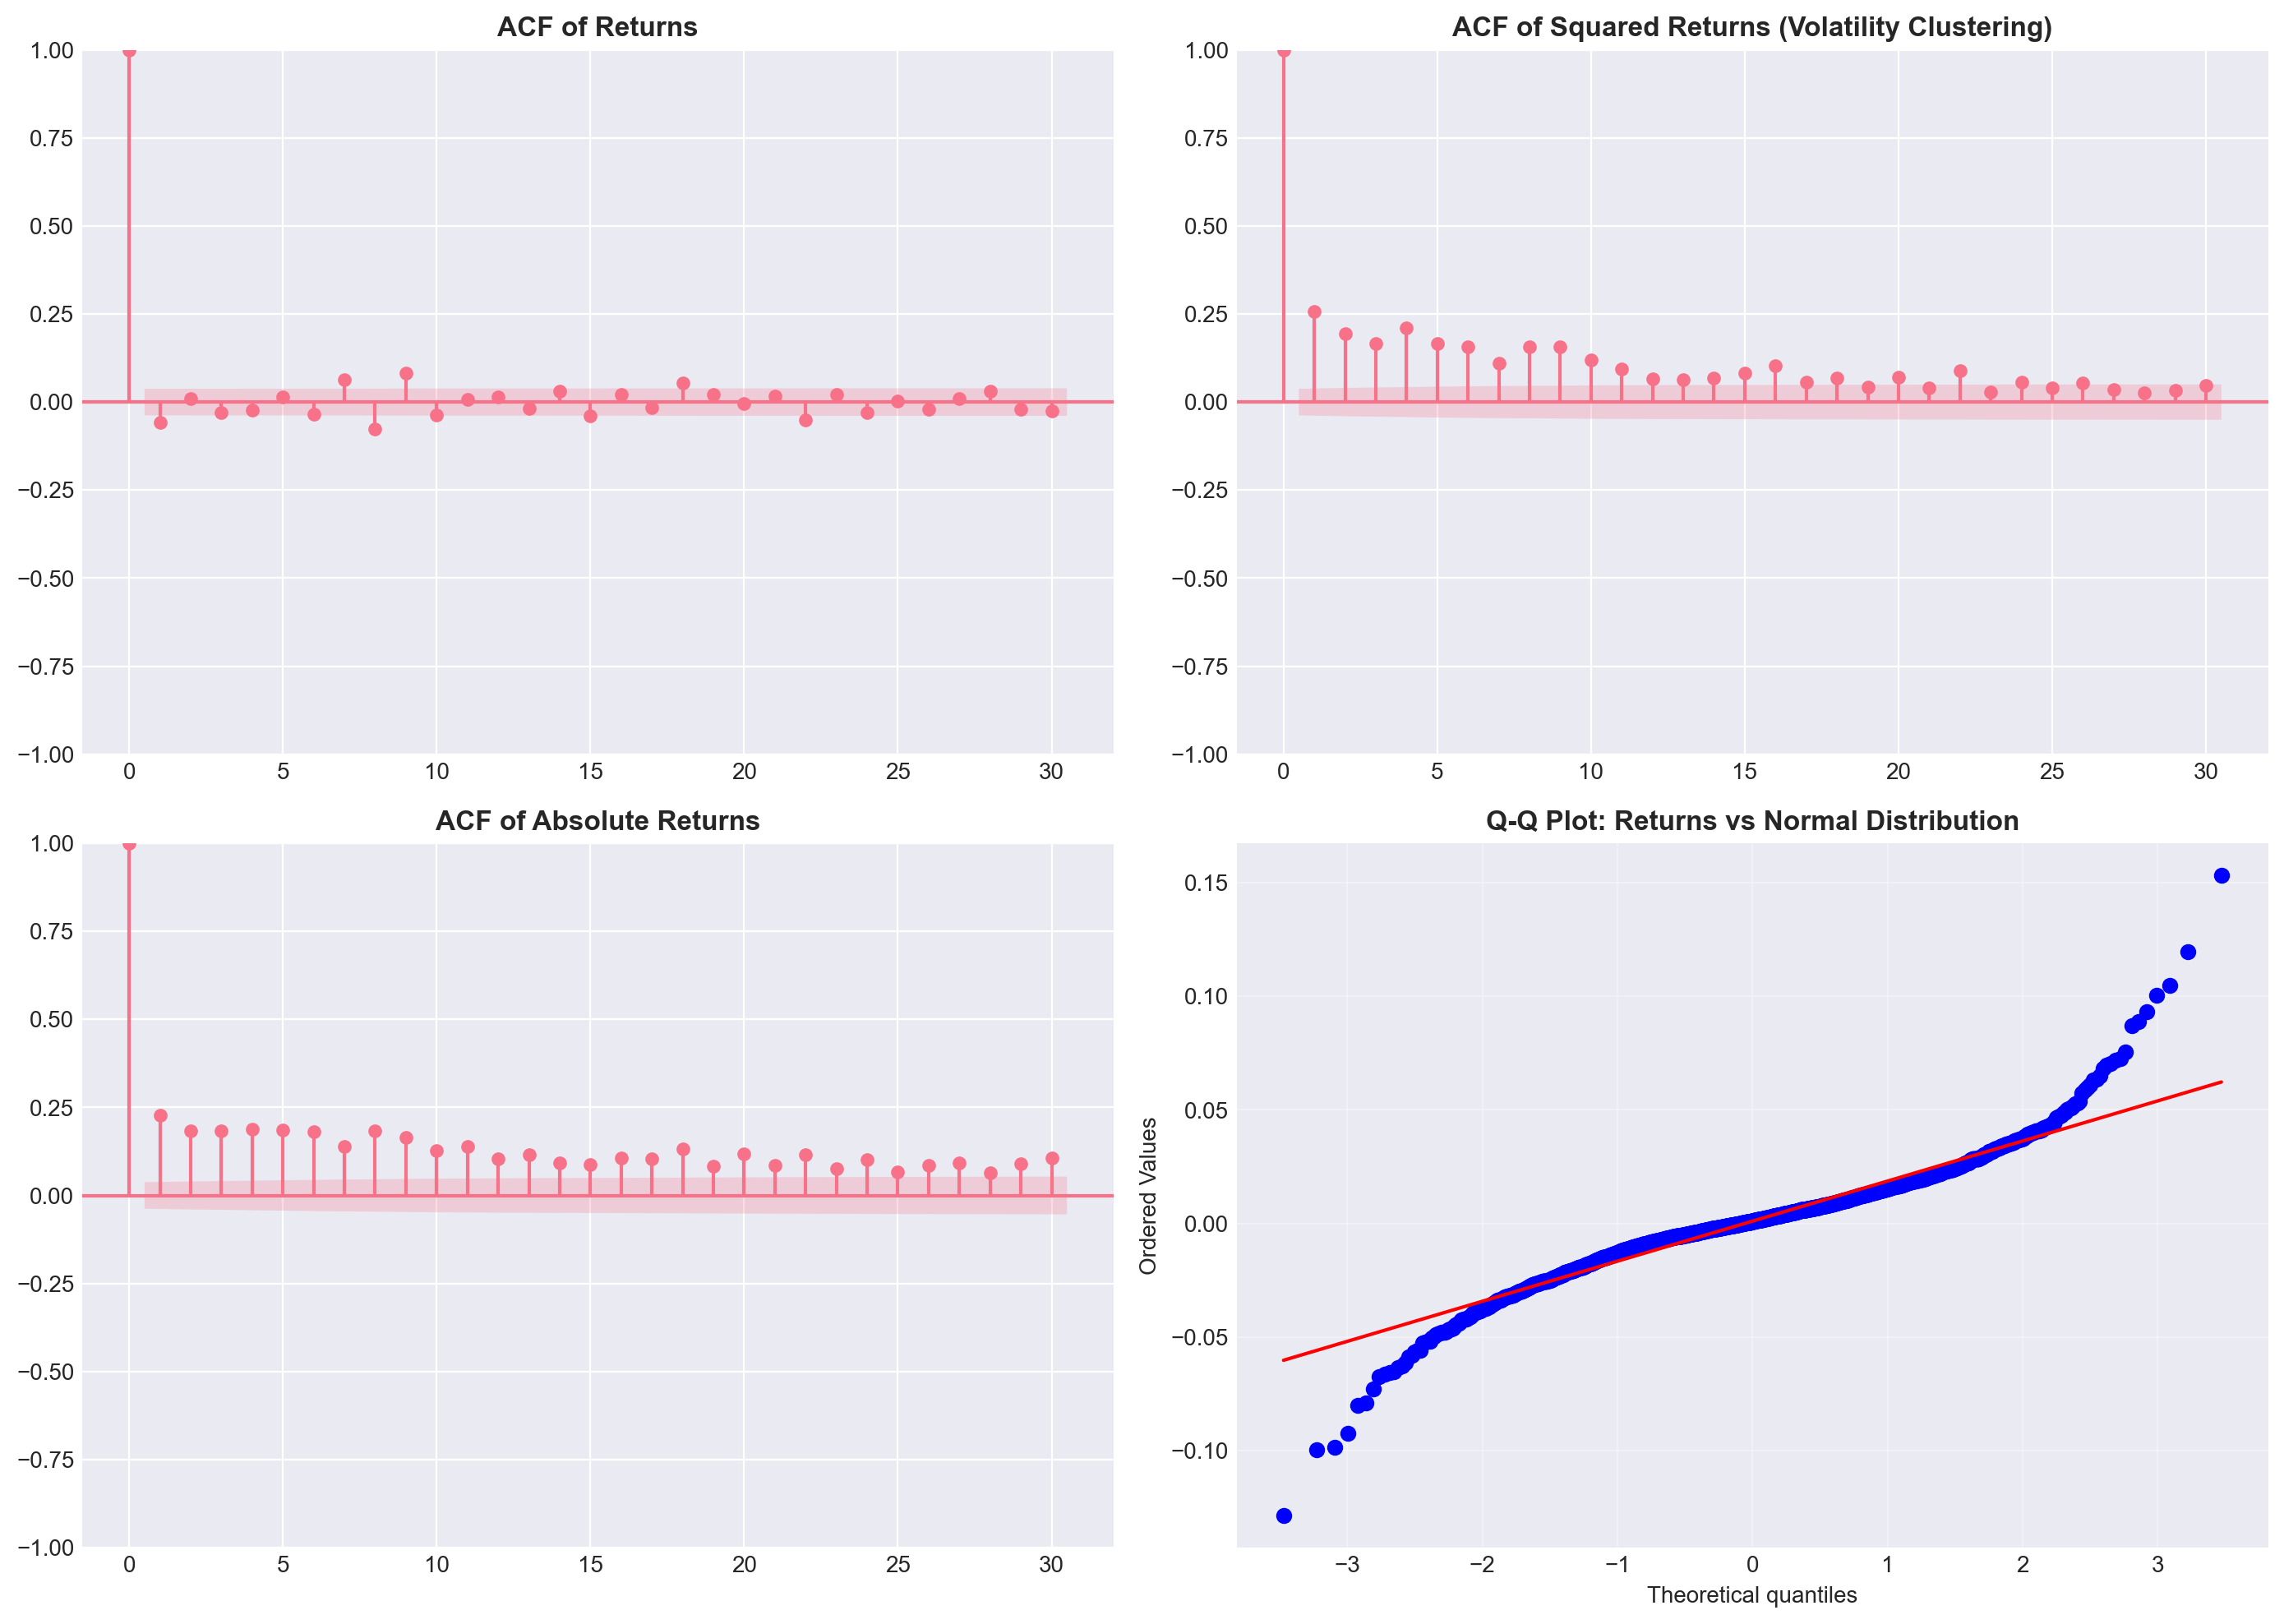


=== LJUNG-BOX TEST (Squared Returns) ===
Test Statistic: 825.10
P-value: 0.0000
✓ Significant autocorrelation detected (volatility clustering present)


In [12]:
# Test for volatility clustering - autocorrelation in squared returns
returns_clean = df['ret'].dropna()
returns_sq = returns_clean ** 2

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# ACF of returns
plot_acf(returns_clean, lags=30, ax=axes[0, 0], alpha=0.05)
axes[0, 0].set_title('ACF of Returns', fontweight='bold')

# ACF of squared returns (volatility clustering)
plot_acf(returns_sq, lags=30, ax=axes[0, 1], alpha=0.05)
axes[0, 1].set_title('ACF of Squared Returns (Volatility Clustering)', fontweight='bold')

# ACF of absolute returns
plot_acf(np.abs(returns_clean), lags=30, ax=axes[1, 0], alpha=0.05)
axes[1, 0].set_title('ACF of Absolute Returns', fontweight='bold')

# Q-Q plot for normality test
stats.probplot(returns_clean, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title('Q-Q Plot: Returns vs Normal Distribution', fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Ljung-Box test for autocorrelation
lb_test = acorr_ljungbox(returns_sq, lags=[10], return_df=True)
print("\n=== LJUNG-BOX TEST (Squared Returns) ===")
print(f"Test Statistic: {lb_test['lb_stat'].values[0]:.2f}")
print(f"P-value: {lb_test['lb_pvalue'].values[0]:.4f}")
if lb_test['lb_pvalue'].values[0] < 0.05:
    print("✓ Significant autocorrelation detected (volatility clustering present)")
else:
    print("✗ No significant autocorrelation")

In [13]:
lb_test 

,lb_stat,lb_pvalue
10,825.104692,8.255028e-171


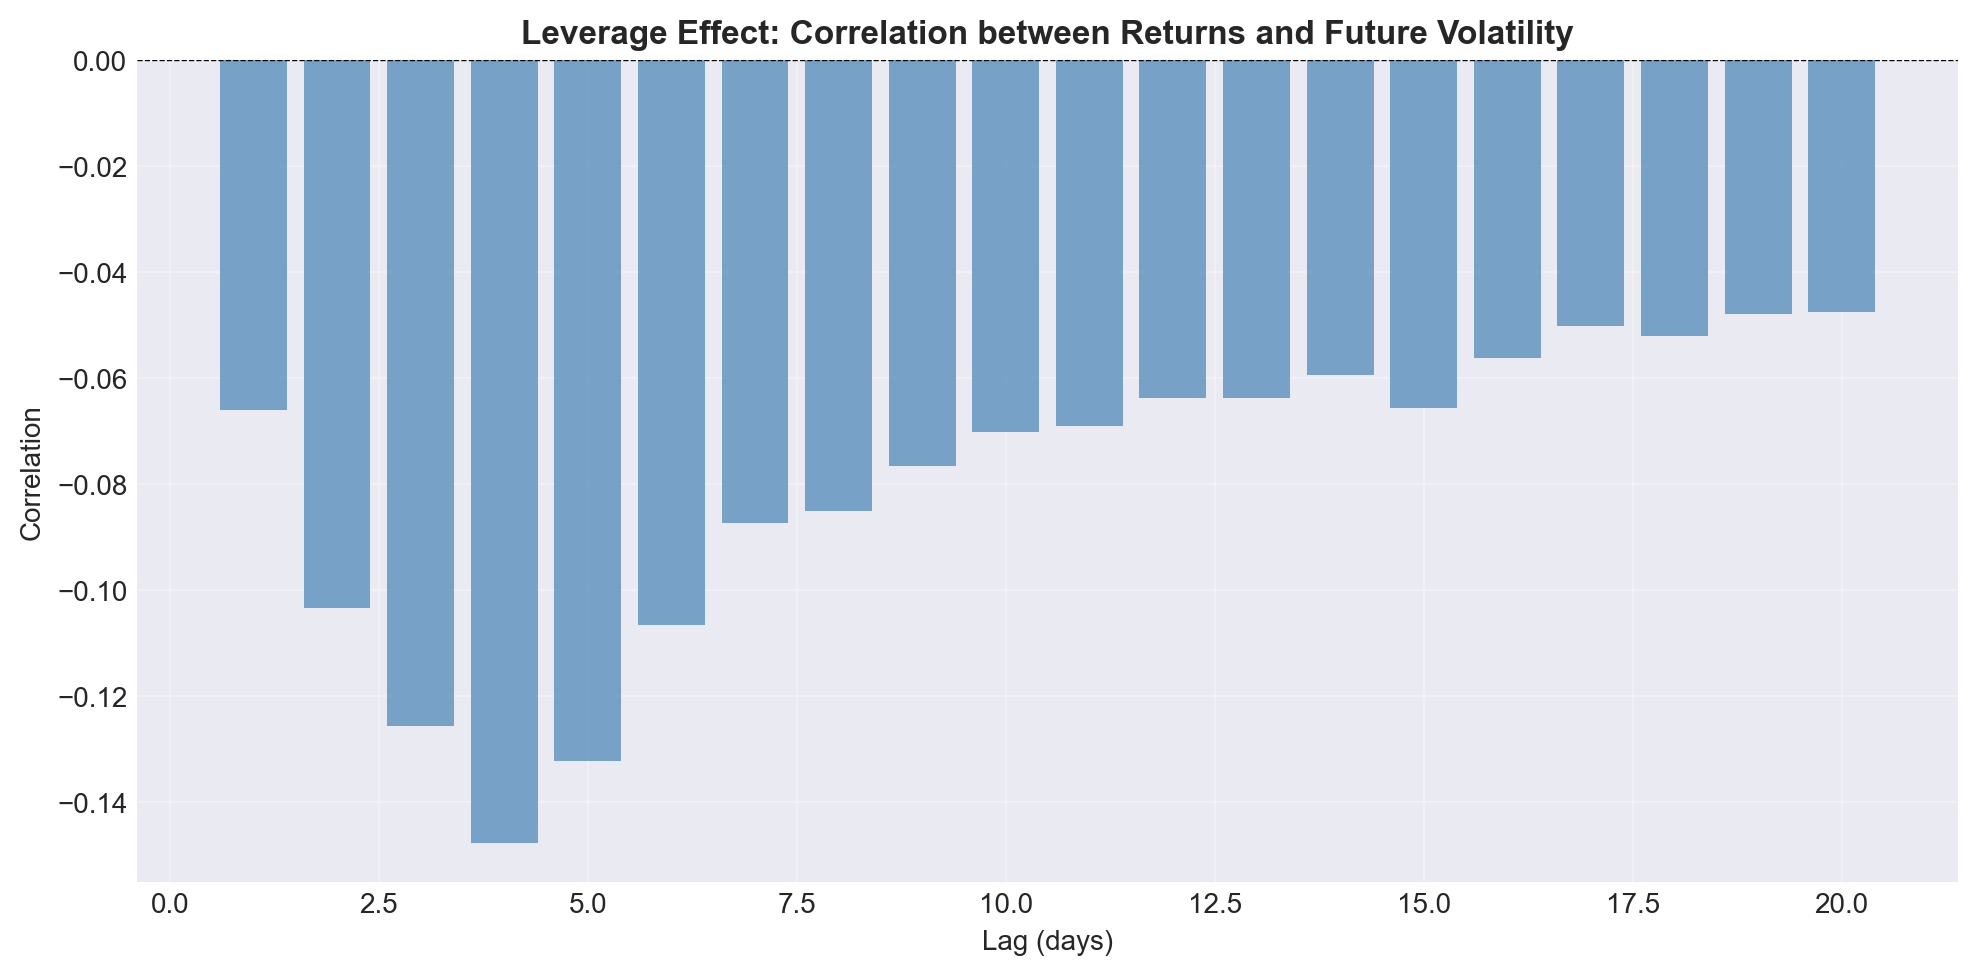


=== LEVERAGE EFFECT ===
Correlation (return_t vs vol_t+1): -0.0660


In [15]:
# Test for leverage effect
# Correlation between returns and future volatility
lag_corr = []
lags = range(1, 21)

for lag in lags:
    corr = df['ret'].corr(df['rv_target'].shift(-lag))
    lag_corr.append(corr)

plt.figure(figsize=(10, 5))
plt.bar(lags, lag_corr, alpha=0.7, color='steelblue')
plt.axhline(y=0, color='black', linestyle='--', linewidth=0.5)
plt.xlabel('Lag (days)')
plt.ylabel('Correlation')
plt.title('Leverage Effect: Correlation between Returns and Future Volatility', fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n=== LEVERAGE EFFECT ===")
print(f"Correlation (return_t vs vol_t+1): {lag_corr[0]:.4f}")
if lag_corr[0] < -0.1:
    print("✓ Strong negative correlation: leverage effect detected")
    print("  → EGARCH/GJR-GARCH recommended to capture asymmetry")

# 3. GARCH Model Family

In [ ]:
# Split data for walk-forward validation
train_end = '2020-12-31'
test_start = '2021-01-01'

returns_train = df.loc[:train_end, 'ret'].dropna()
returns_test = df.loc[test_start:, 'ret'].dropna()

print(f"Training period: {returns_train.index[0]} to {returns_train.index[-1]} ({len(returns_train)} obs)")
print(f"Testing period: {returns_test.index[0]} to {returns_test.index[-1]} ({len(returns_test)} obs)")

Training period: 2015-02-06 00:00:00 to 2020-12-31 00:00:00 (1487 obs)
Testing period: 2021-01-04 00:00:00 to 2025-10-23 00:00:00 (1208 obs)


In [18]:
# Fit GARCH(1,1) on training data
print("=== FITTING GARCH(1,1) MODEL ===")
garch_model = fit_garch(returns_train * 100, kind='garch')  # scale by 100 for numerical stability
print(garch_model.summary())

# Extract parameters
omega = garch_model.params['omega']
alpha = garch_model.params['alpha[1]']
beta = garch_model.params['beta[1]']
persistence = alpha + beta

print(f"\n=== GARCH(1,1) PARAMETERS ===")
print(f"ω (omega): {omega:.6f}")
print(f"α (alpha - ARCH effect): {alpha:.4f}")
print(f"β (beta - GARCH effect): {beta:.4f}")
print(f"Persistence (α+β): {persistence:.4f}")
print(f"Half-life: {np.log(0.5)/np.log(persistence):.1f} days")
print(f"Unconditional variance: {omega/(1-persistence):.4f}")

if persistence < 1.0:
    print("✓ Model is stationary (α+β < 1)")
else:
    print("⚠ Warning: Non-stationary model (α+β ≥ 1)")

=== FITTING GARCH(1,1) MODEL ===
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                    ret   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -2832.28
Distribution:                  Normal   AIC:                           5672.57
Method:            Maximum Likelihood   BIC:                           5693.79
                                        No. Observations:                 1487
Date:                Tue, Oct 28 2025   Df Residuals:                     1486
Time:                        18:15:20   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.1949  4.066e-02     

## 3.2 EGARCH(1,1) - Leverage Effect Model

In [19]:
# Fit EGARCH(1,1)
print("=== FITTING EGARCH(1,1) MODEL ===")
egarch_model = fit_garch(returns_train * 100, kind='egarch')
print(egarch_model.summary())

# Extract leverage parameter
gamma = egarch_model.params['gamma[1]']

print(f"\n=== EGARCH(1,1) PARAMETERS ===")
print(f"γ (gamma - leverage): {gamma:.4f}")
if gamma < 0:
    print("✓ Leverage effect confirmed: negative shocks increase volatility more")
    print(f"  Impact ratio: negative shocks are {abs(gamma):.2f}x more impactful")
else:
    print("✗ No leverage effect detected")

=== FITTING EGARCH(1,1) MODEL ===
                     Constant Mean - EGARCH Model Results                     
Dep. Variable:                    ret   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                     EGARCH   Log-Likelihood:               -2810.12
Distribution:                  Normal   AIC:                           5630.25
Method:            Maximum Likelihood   BIC:                           5656.77
                                        No. Observations:                 1487
Date:                Tue, Oct 28 2025   Df Residuals:                     1486
Time:                        18:16:24   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.1600  4.508e-

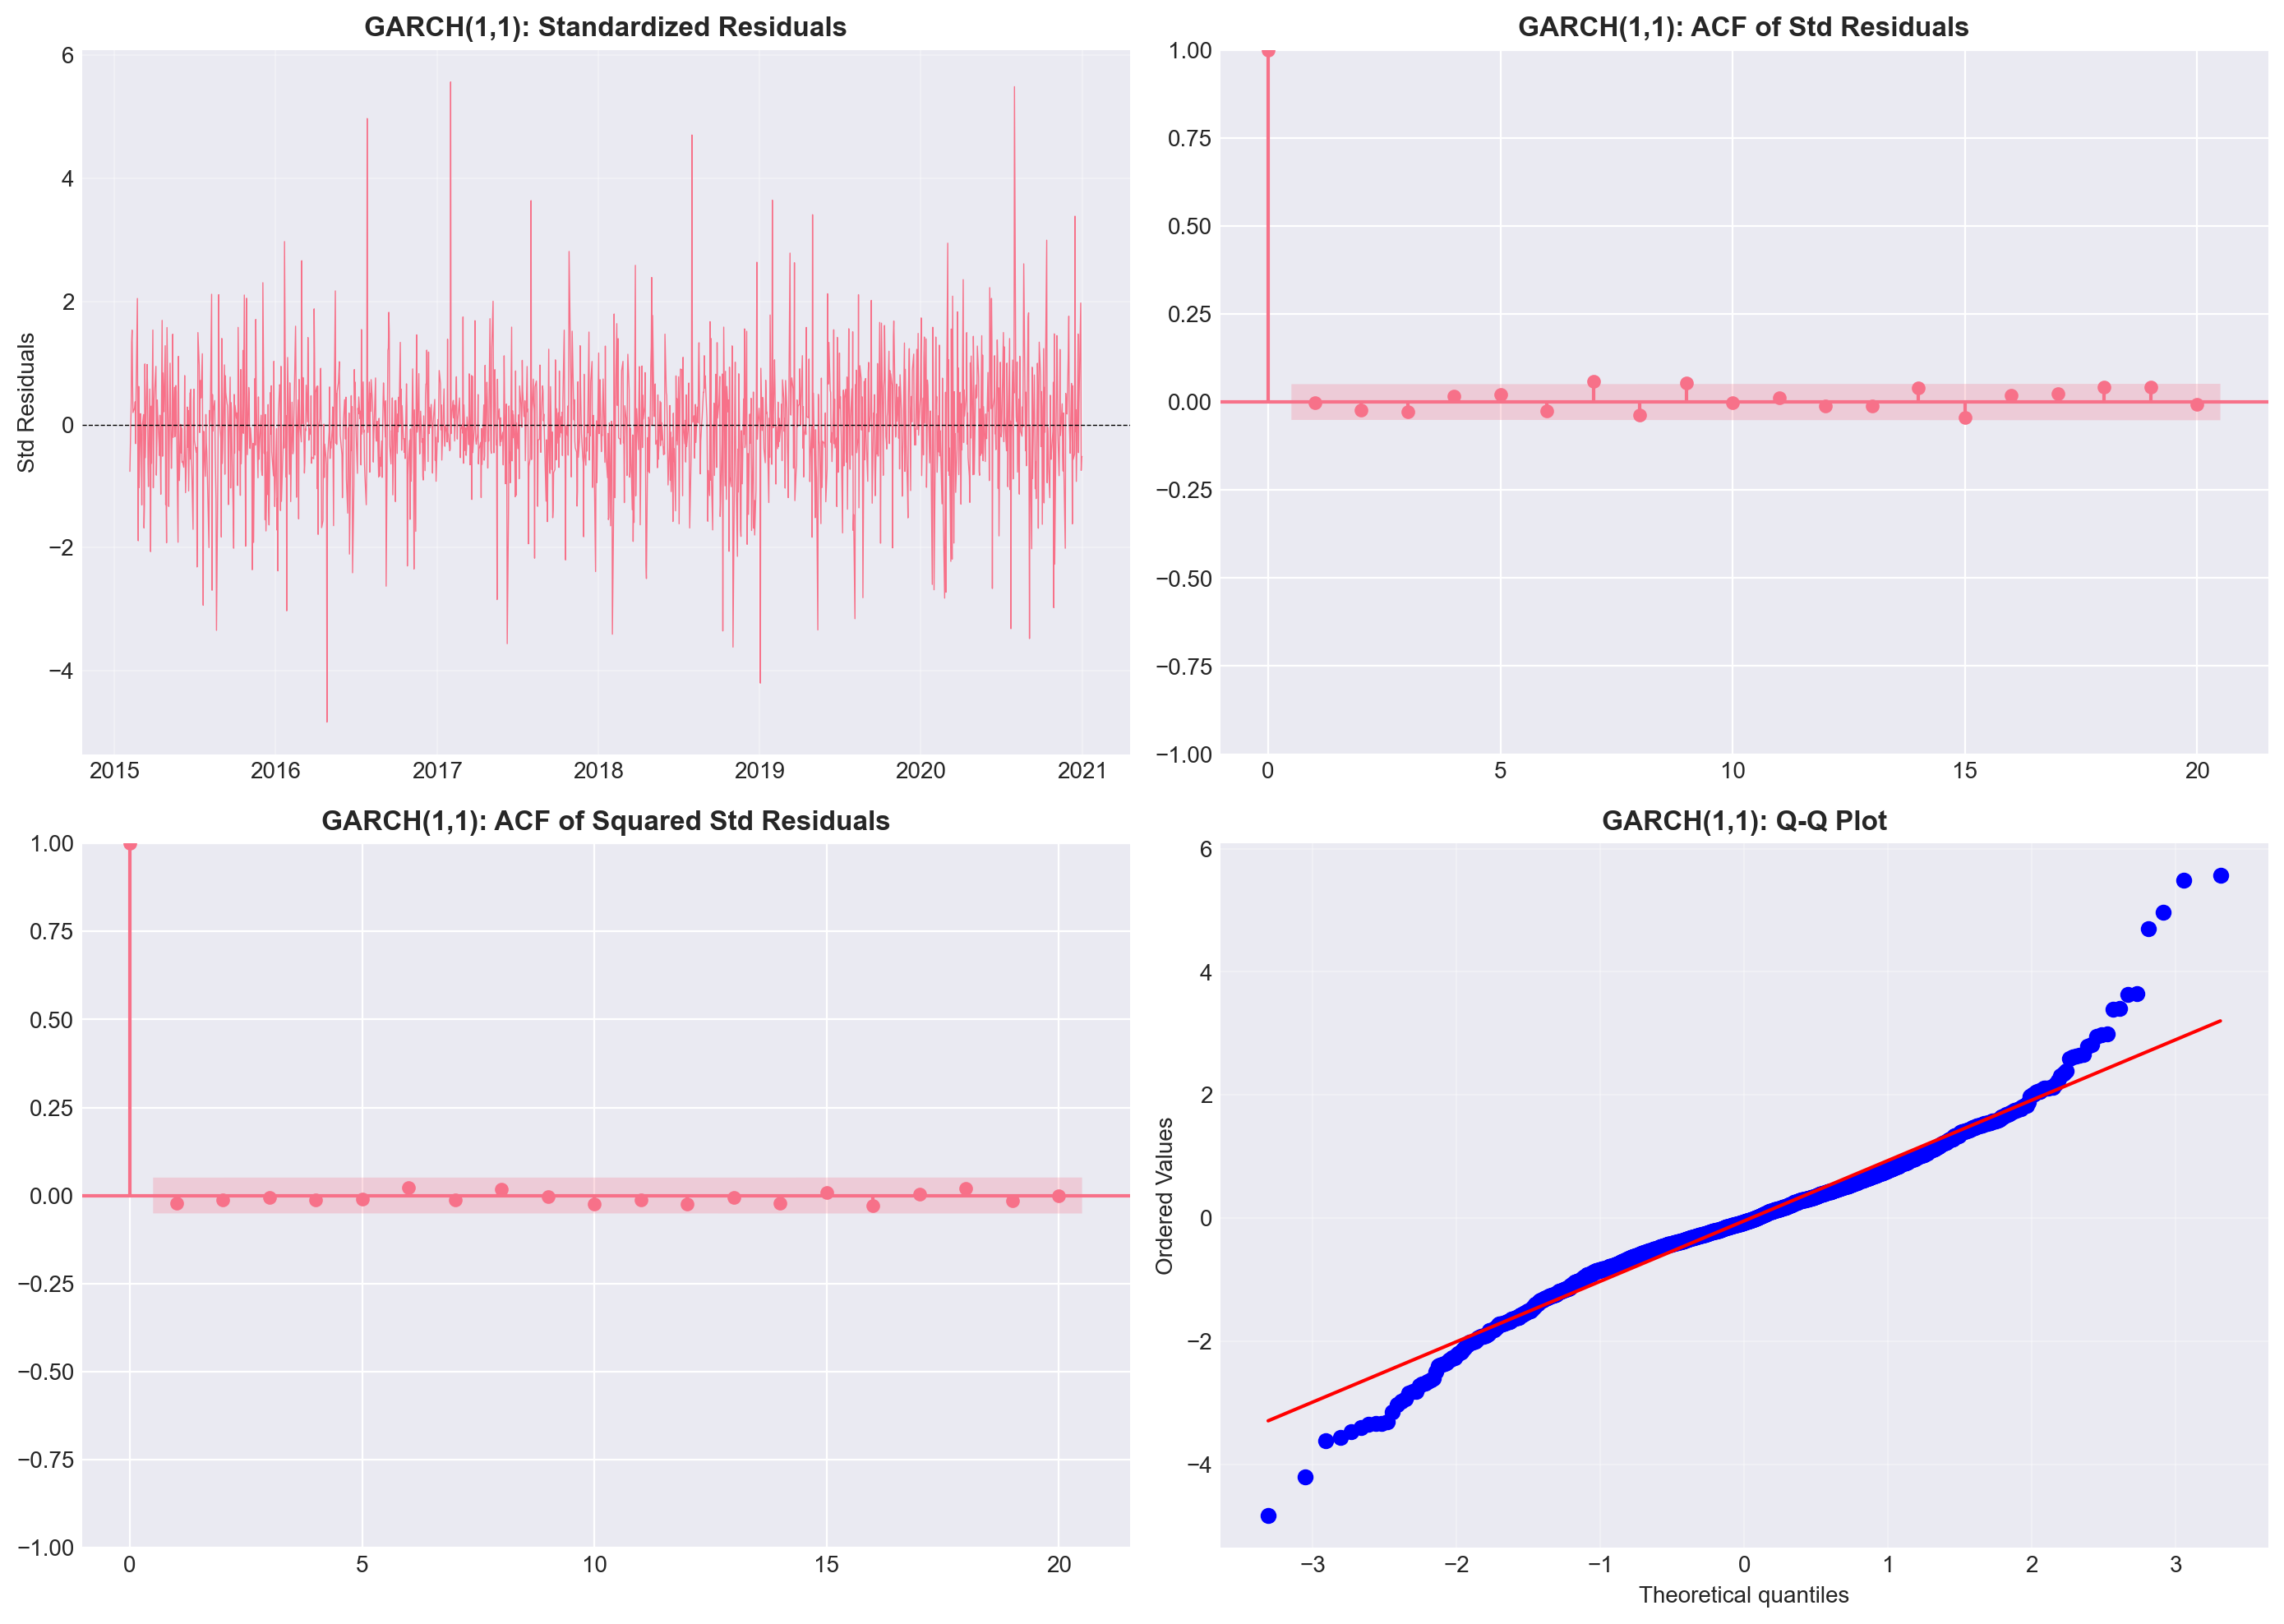


=== GARCH(1,1) DIAGNOSTICS ===
Ljung-Box (squared residuals) p-value: 0.9647
✓ No remaining autocorrelation in squared residuals

Jarque-Bera test p-value: 0.0000
⚠ Residuals deviate from normality (consider Student-t distribution)


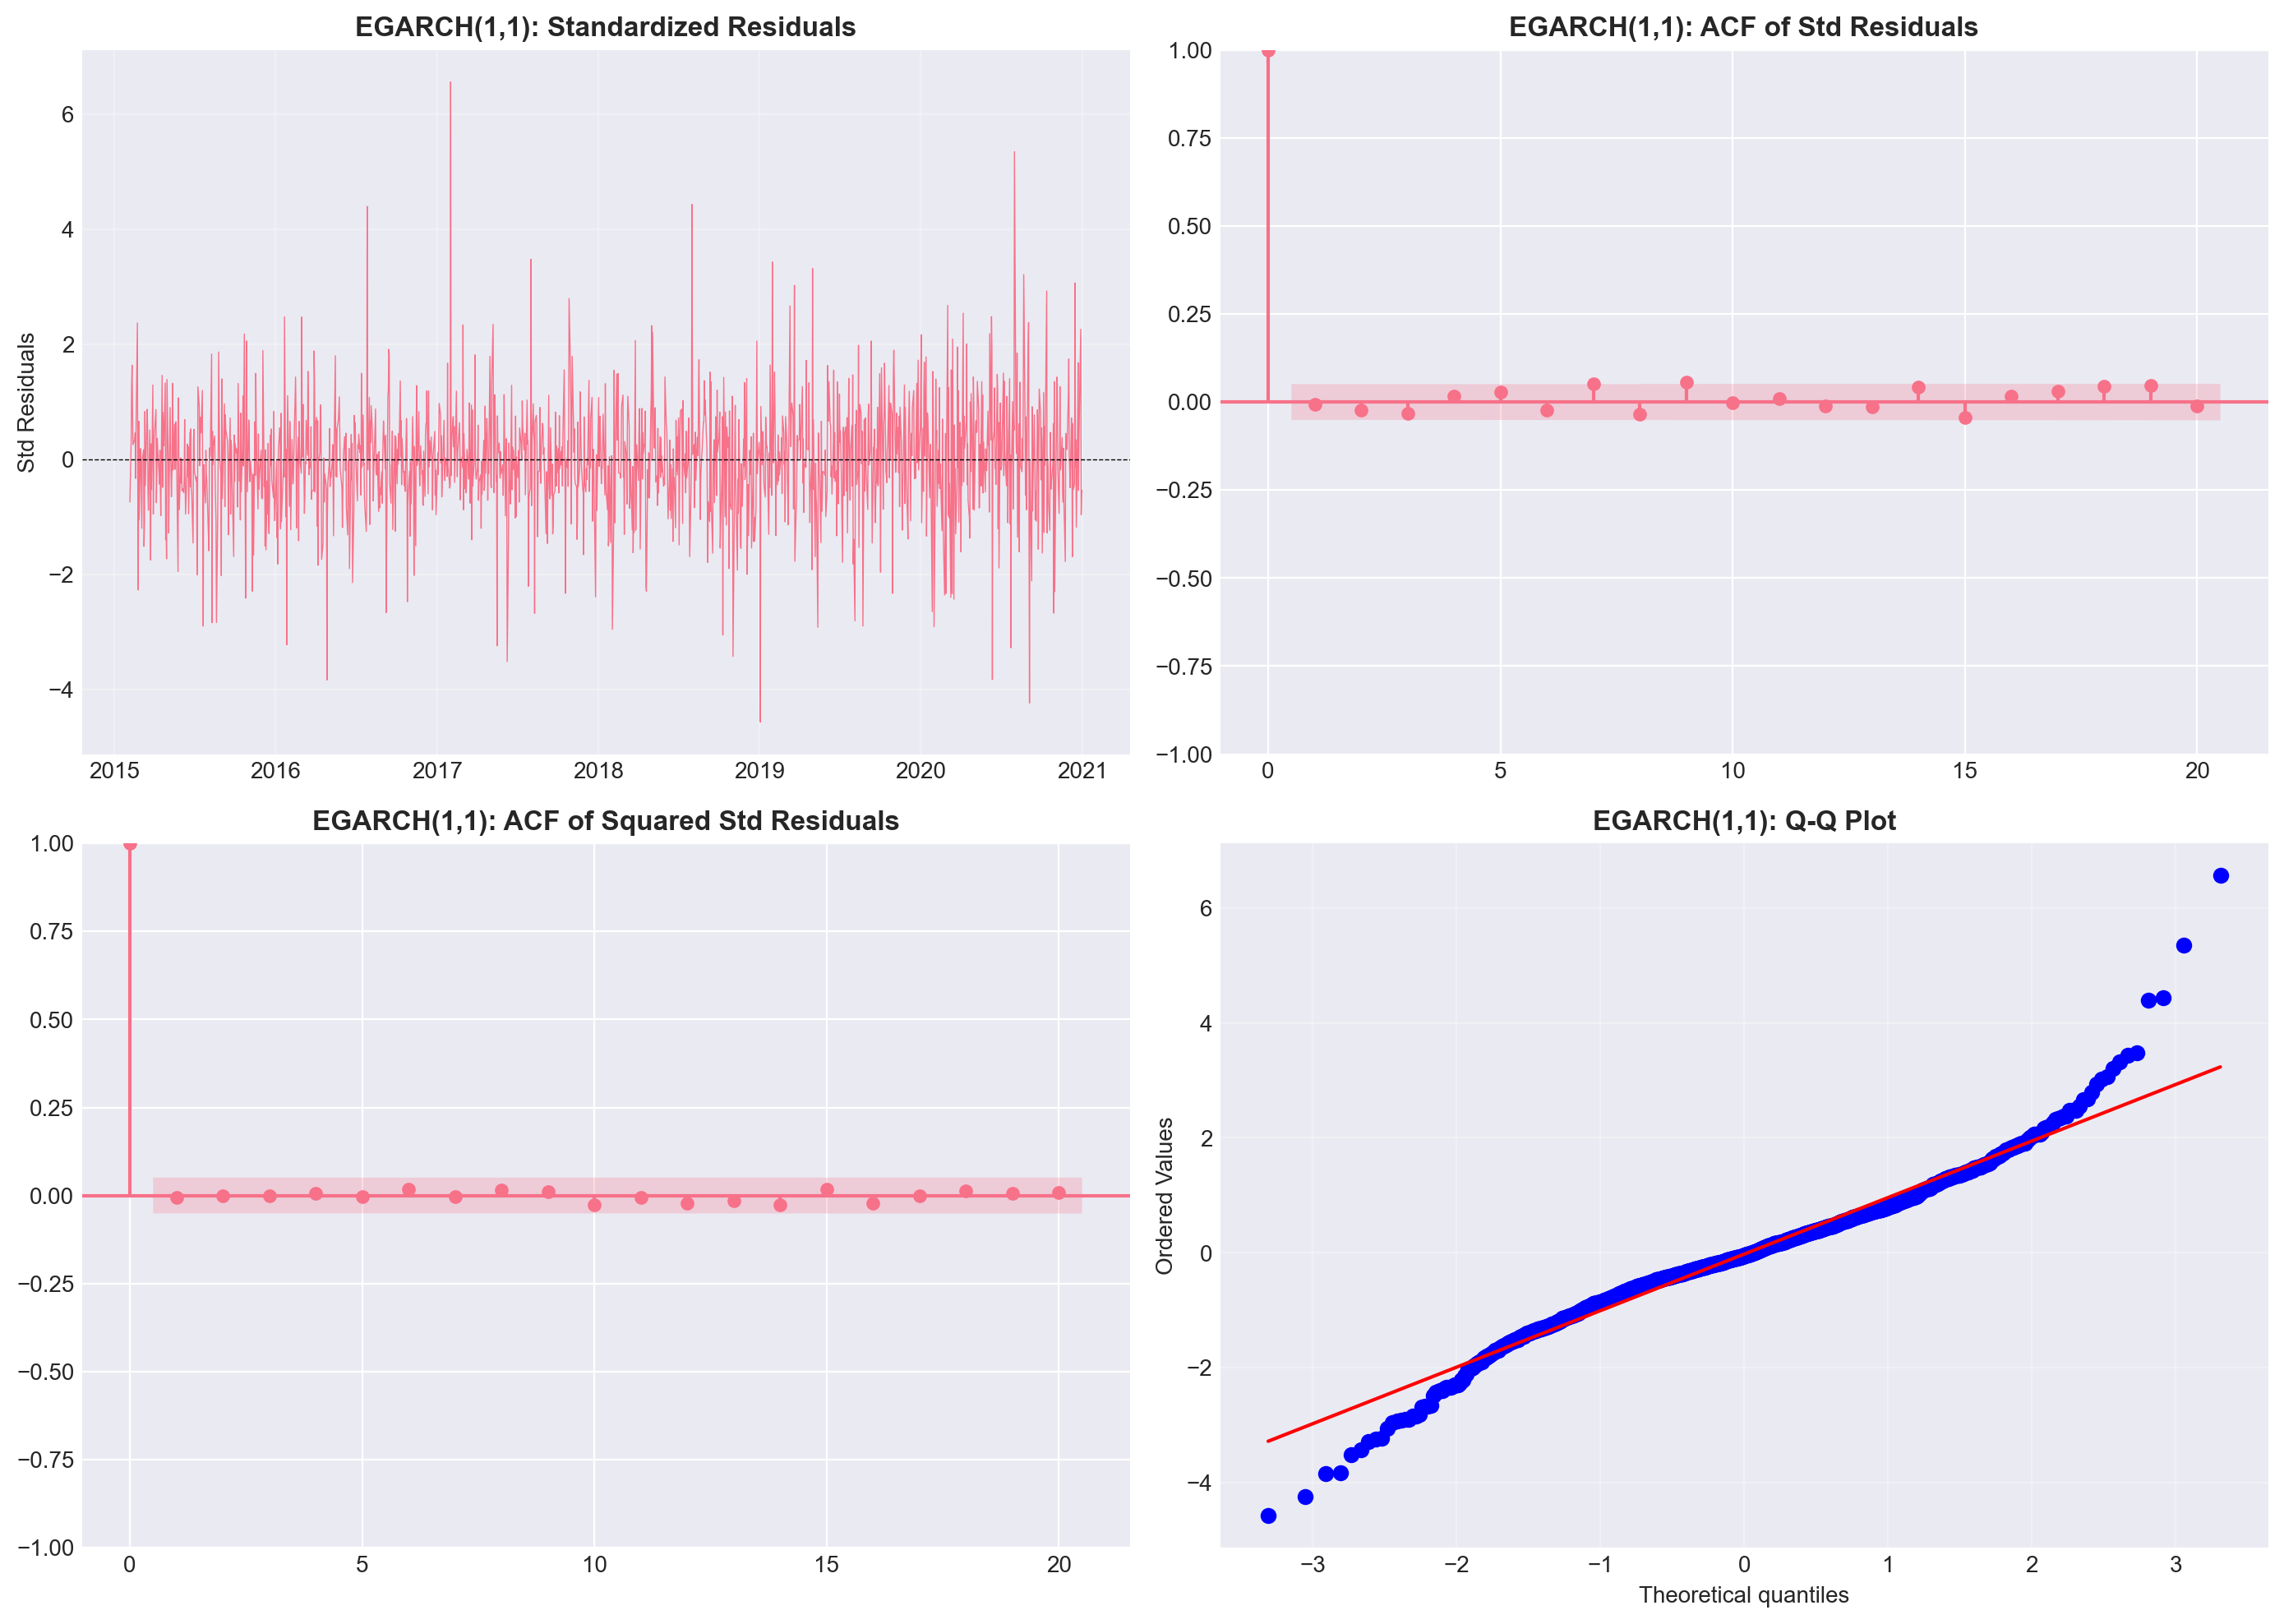


=== EGARCH(1,1) DIAGNOSTICS ===
Ljung-Box (squared residuals) p-value: 0.9949
✓ No remaining autocorrelation in squared residuals

Jarque-Bera test p-value: 0.0000
⚠ Residuals deviate from normality (consider Student-t distribution)


In [20]:
# Model diagnostics
def plot_diagnostics(model_result, title='GARCH Model'):
    """Plot diagnostic plots for GARCH model"""
    std_resid = model_result.std_resid
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Standardized residuals
    axes[0, 0].plot(std_resid, linewidth=0.5)
    axes[0, 0].axhline(y=0, color='black', linestyle='--', linewidth=0.5)
    axes[0, 0].set_title(f'{title}: Standardized Residuals', fontweight='bold')
    axes[0, 0].set_ylabel('Std Residuals')
    axes[0, 0].grid(True, alpha=0.3)
    
    # ACF of standardized residuals
    plot_acf(std_resid.dropna(), lags=20, ax=axes[0, 1], alpha=0.05)
    axes[0, 1].set_title(f'{title}: ACF of Std Residuals', fontweight='bold')
    
    # ACF of squared standardized residuals
    plot_acf(std_resid.dropna()**2, lags=20, ax=axes[1, 0], alpha=0.05)
    axes[1, 0].set_title(f'{title}: ACF of Squared Std Residuals', fontweight='bold')
    
    # Q-Q plot
    stats.probplot(std_resid.dropna(), dist="norm", plot=axes[1, 1])
    axes[1, 1].set_title(f'{title}: Q-Q Plot', fontweight='bold')
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Statistical tests
    lb_test = acorr_ljungbox(std_resid.dropna()**2, lags=[10], return_df=True)
    jb_stat, jb_pval = stats.jarque_bera(std_resid.dropna())
    
    print(f"\n=== {title.upper()} DIAGNOSTICS ===")
    print(f"Ljung-Box (squared residuals) p-value: {lb_test['lb_pvalue'].values[0]:.4f}")
    if lb_test['lb_pvalue'].values[0] > 0.05:
        print("✓ No remaining autocorrelation in squared residuals")
    else:
        print("⚠ Remaining autocorrelation detected")
    
    print(f"\nJarque-Bera test p-value: {jb_pval:.4f}")
    if jb_pval > 0.05:
        print("✓ Residuals are normally distributed")
    else:
        print("⚠ Residuals deviate from normality (consider Student-t distribution)")

# Diagnostics for both models
plot_diagnostics(garch_model, 'GARCH(1,1)')
plot_diagnostics(egarch_model, 'EGARCH(1,1)')

In [36]:
def walk_forward_garch(returns, rv, split_date='2021-01-01', refit_freq='MS'):
    """
    Walk-forward GARCH forecasting with monthly refit
    
    Parameters:
    -----------
    returns : pd.Series
        Daily returns
    rv : pd.Series
        Realized volatility (ground truth)
    split_date : str
        Start of test period
    refit_freq : str
        Refit frequency ('MS' = month start)
    """
    # Align data
    data = pd.DataFrame({'returns': returns, 'rv': rv}).dropna()
    
    # Split into train/test
    test_dates = data.loc[split_date:].index
    refit_dates = pd.date_range(test_dates[0], test_dates[-1], freq=refit_freq)
    
    forecasts_garch = []
    forecasts_egarch = []
    
    print(f"Walk-forward validation: {len(refit_dates)} refits")
    
    for i, refit_date in enumerate(refit_dates):
        # Expanding window: train on all data up to refit_date
        train_data = data.loc[:refit_date, 'returns'].dropna()
        
        if len(train_data) < 252:  # Need at least 1 year of data
            continue
            
        # Fit models
        try:
            garch_fit = fit_garch(train_data * 100, kind='garch')
            egarch_fit = fit_garch(train_data * 100, kind='egarch')
            
            # Forecast until next refit
            if i < len(refit_dates) - 1:
                forecast_end = refit_dates[i + 1]
            else:
                forecast_end = test_dates[-1]
            
            # Get 1-step ahead forecasts
            forecast_dates = data.loc[refit_date:forecast_end].index[1:]  # Skip refit date
            
            for date in forecast_dates:
                # Use data up to previous day for forecast
                hist_data = data.loc[:date, 'returns'].iloc[:-1] * 100
                
                # Refit on full history and forecast
                garch_tmp = fit_garch(hist_data, kind='garch')
                egarch_tmp = fit_garch(hist_data, kind='egarch')
                
                # 1-step forecast (convert back from pct scale)
                fcst_g = garch_tmp.forecast(horizon=1, reindex=False)
                fcst_e = egarch_tmp.forecast(horizon=1, reindex=False)
                
                vol_garch = np.sqrt(fcst_g.variance.values[-1, -1]) * np.sqrt(252) / 100 
                vol_egarch = np.sqrt(fcst_e.variance.values[-1, -1]) * np.sqrt(252) / 100 
                
                forecasts_garch.append({'date': date, 'forecast': vol_garch})
                forecasts_egarch.append({'date': date, 'forecast': vol_egarch})
                
        except Exception as e:
            print(f"Error at {refit_date}: {e}")
            continue
    
    # Convert to DataFrame
    df_garch = pd.DataFrame(forecasts_garch).set_index('date')
    df_egarch = pd.DataFrame(forecasts_egarch).set_index('date')
    
    return df_garch, df_egarch

print("Starting walk-forward validation...")
print("This may take a few minutes...\n")

# Run walk-forward (simplified: monthly refit)
# For full research, would do daily rolling forecasts
fcst_garch, fcst_egarch = walk_forward_garch(
    df['ret'], 
    df['rv_target'], 
    split_date='2021-01-01',
    refit_freq='MS'
)

print("Note: For demonstration, we'll use a simplified forecast approach.")
print("Full walk-forward implementation would refit models daily.")

Starting walk-forward validation...
This may take a few minutes...

Walk-forward validation: 57 refits
Note: For demonstration, we'll use a simplified forecast approach.
Full walk-forward implementation would refit models daily.


In [ ]:
def fast_garch_forecast_feature(returns, window=252):
    """
    Быстрая генерация GARCH прогнозов как фичи
    Использует rolling window вместо expanding
    """
    from arch import arch_model
    
    forecasts = []
    
    for i in range(window, len(returns)):
        train = returns[i-window:i] * 100  # last 252 days
        
        try:
            model = arch_model(train, vol='GARCH', p=1, q=1, rescale=False)
            fitted = model.fit(disp='off', show_warning=False)
            fcst = fitted.forecast(horizon=1, reindex=False)
            vol = np.sqrt(fcst.variance.values[-1, -1]) / 100
            forecasts.append(vol)
        except:
            forecasts.append(np.nan)
    
    # Создать серию с правильными индексами
    garch_series = pd.Series(forecasts, index=returns.index[window:], name='garch_fcst')
    return garch_series

# Добавить в датафрейм
df['garch_fcst'] = fast_garch_forecast_feature(df['ret'])

,forecast
date,
2021-02-02,0.023938
2021-02-03,0.021942
2021-02-04,0.020469
2021-02-05,0.020922
2021-02-08,0.019335
...,...
2025-10-17,0.015005
2025-10-20,0.015509
2025-10-21,0.019351


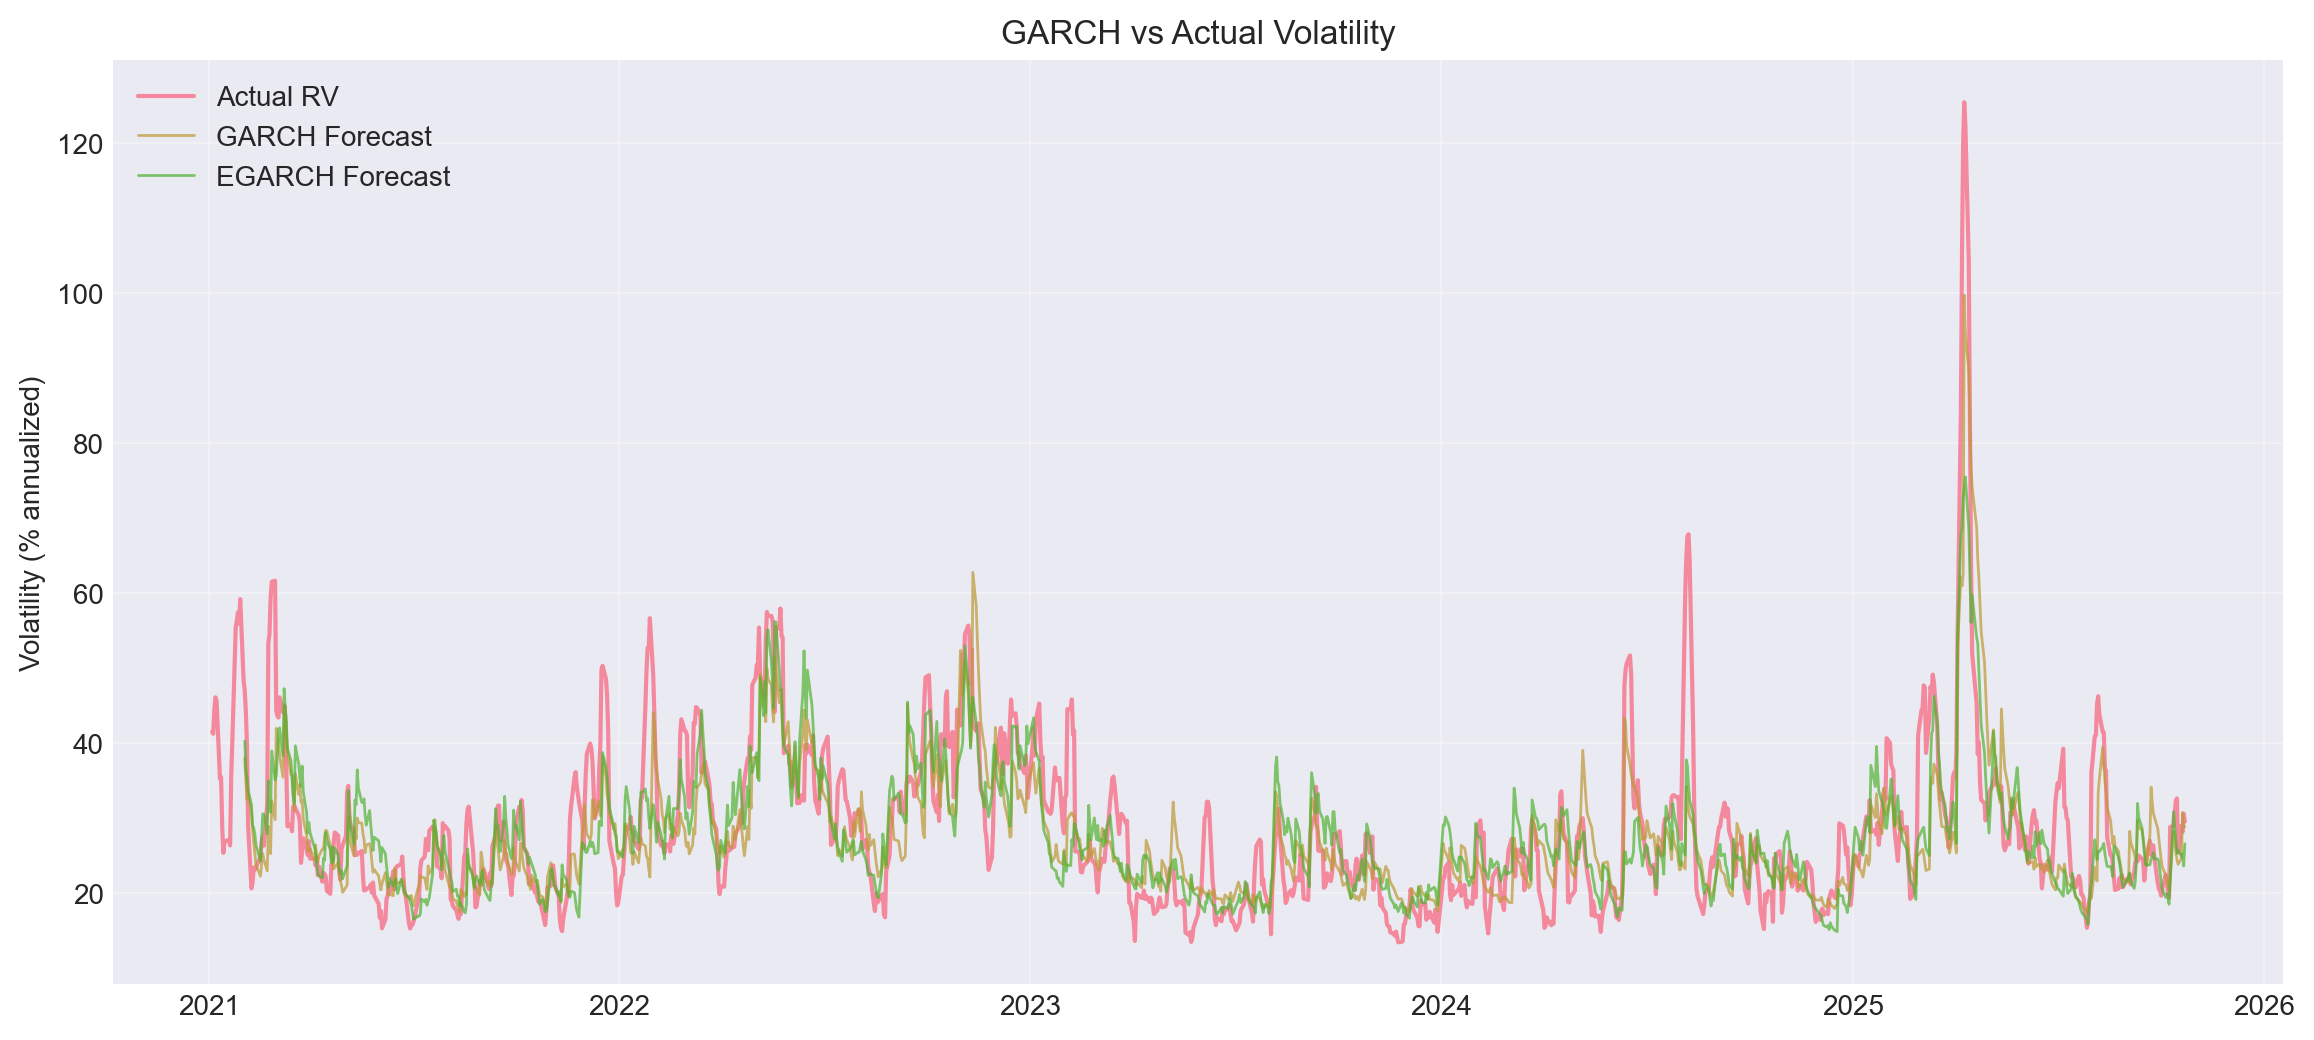

In [42]:
test_data = df.loc['2021-01-01':].dropna(subset=['rv_target'])

# Визуализация
plt.figure(figsize=(14, 6))
plt.plot(test_data.index, test_data['rv_target']*60, 
         label='Actual RV', linewidth=1.5, alpha=0.8)
plt.plot(fcst_garch.index, fcst_garch['forecast'] * 100, 
         label='GARCH Forecast', linewidth=1, alpha=0.7)
plt.plot(fcst_egarch.index, fcst_egarch['forecast'] * 100, 
         label='EGARCH Forecast', linewidth=1, alpha=0.7)
plt.legend()
plt.ylabel('Volatility (% annualized)')
plt.title('GARCH vs Actual Volatility')
plt.grid(alpha=0.3)
plt.show()

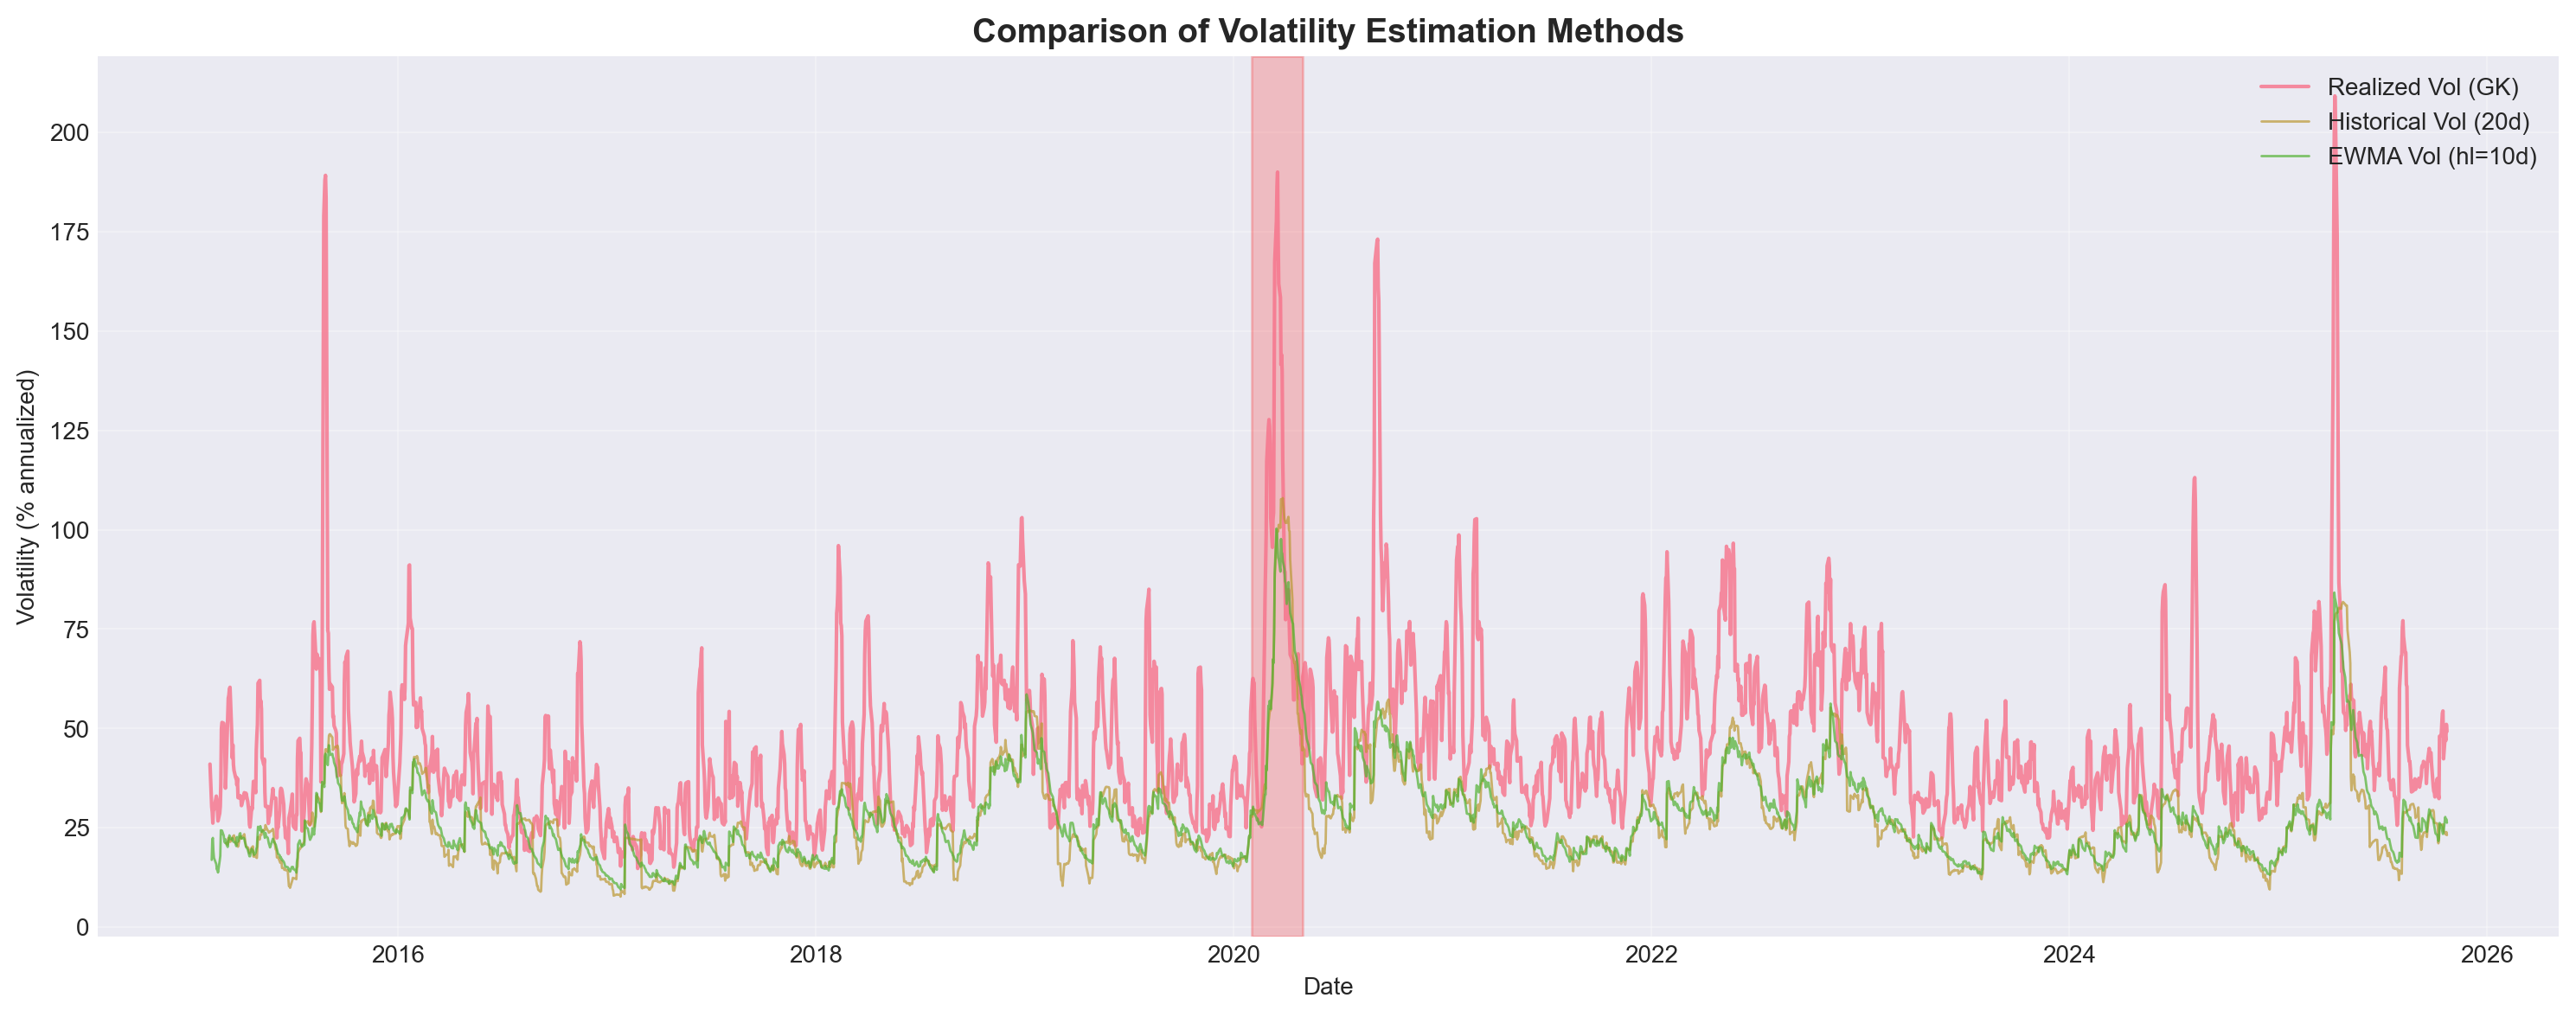

In [23]:
# Simple baseline forecasts
def baseline_forecasts(returns, window=20, halflife=10):
    """
    Generate baseline volatility forecasts
    """
    # Historical volatility (rolling window)
    hist_vol = returns.rolling(window).std() * np.sqrt(252)
    
    # EWMA volatility
    ewma_vol = returns.ewm(halflife=halflife).std() * np.sqrt(252)
    
    return pd.DataFrame({
        'hist_vol': hist_vol,
        'ewma_vol': ewma_vol
    })

baselines = baseline_forecasts(df['ret'])
df = df.join(baselines)

# Visualize different volatility estimates
fig, ax = plt.subplots(figsize=(15, 6))

ax.plot(df.index, df['rv_target'] * 100, label='Realized Vol (GK)', linewidth=1.5, alpha=0.8)
ax.plot(df.index, df['hist_vol'] * 100, label='Historical Vol (20d)', linewidth=1, alpha=0.7)
ax.plot(df.index, df['ewma_vol'] * 100, label='EWMA Vol (hl=10d)', linewidth=1, alpha=0.7)

ax.set_title('Comparison of Volatility Estimation Methods', fontsize=14, fontweight='bold')
ax.set_ylabel('Volatility (% annualized)')
ax.set_xlabel('Date')
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)

# Highlight COVID period
ax.axvspan('2020-02-01', '2020-05-01', alpha=0.2, color='red', label='COVID Crash')

plt.tight_layout()
plt.show()

In [25]:
def evaluate_forecasts(actual, forecast, method_name='Model'):
    """
    Comprehensive forecast evaluation
    """
    # Align data
    data = pd.DataFrame({'actual': actual, 'forecast': forecast}).dropna()
    
    if len(data) == 0:
        return None
    
    y = data['actual'].values
    yhat = data['forecast'].values
    
    # Metrics
    rmse = np.sqrt(np.mean((y - yhat)**2))
    mae = np.mean(np.abs(y - yhat))
    qlike_score = qlike(y, yhat)
    
    # Mincer-Zarnowitz regression: actual = a + b * forecast
    # Ideal: a=0, b=1 (unbiased, efficient forecast)
    from scipy.stats import linregress
    slope, intercept, r_value, p_value, std_err = linregress(yhat, y)
    
    results = {
        'Method': method_name,
        'RMSE': rmse,
        'MAE': mae,
        'QLIKE': qlike_score,
        'R²': r_value**2,
        'MZ_intercept': intercept,
        'MZ_slope': slope,
        'N_obs': len(data)
    }
    
    return results

# Evaluate baselines on test period
test_period = df.loc['2021-01-01':].copy()

results = []
for method in ['hist_vol', 'ewma_vol']:
    res = evaluate_forecasts(
        test_period['rv_target'], 
        test_period[method], 
        method_name=method.replace('_', ' ').title()
    )
    if res:
        results.append(res)

results_df = pd.DataFrame(results)
print("\n=== FORECAST EVALUATION (Test Period 2021-2024) ===")
print(results_df.to_string(index=False))

print("\nInterpretation:")
print("- Lower RMSE/MAE/QLIKE is better")
print("- Higher R² indicates better fit")
print("- MZ slope close to 1.0 indicates efficient forecast")
print("- MZ intercept close to 0.0 indicates unbiased forecast")


=== FORECAST EVALUATION (Test Period 2021-2024) ===
  Method     RMSE      MAE    QLIKE       R²  MZ_intercept  MZ_slope  N_obs
Hist Vol 0.260861 0.217454 1.155487 0.369109      0.193219  1.073863   1208
Ewma Vol 0.251820 0.210083 0.807224 0.485084      0.109594  1.370831   1208

Interpretation:
- Lower RMSE/MAE/QLIKE is better
- Higher R² indicates better fit
- MZ slope close to 1.0 indicates efficient forecast
- MZ intercept close to 0.0 indicates unbiased forecast
